### Authors: Kunal Modi (kjm597), Karan (kx361)

# 1. Import Useful Libraries

In [1]:
# Hide warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing useful libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.pylab as plt
import statsmodels

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller

rcParams['figure.figsize'] = 15, 6
rcParams['figure.dpi'] = 200

%matplotlib inline

import plotly.figure_factory as ff
import plotly.graph_objs as go
import cufflinks as cf

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
cf.go_offline()

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error


# 2. Get the data

In [3]:
# Dictionary of the data
crypto = {}

# Insert the data sets in the dictionary
crypto['bitcoin'] = pd.read_csv('data/bitcoin_price.csv', parse_dates=['Date']).iloc[::-1]
crypto['dash'] = pd.read_csv("data/dash_price.csv", parse_dates=['Date']).iloc[::-1]
crypto['ethereum'] = pd.read_csv("data/ethereum_price.csv", parse_dates=['Date']).iloc[::-1]
crypto['litecoin'] = pd.read_csv("data/litecoin_price.csv", parse_dates=['Date']).iloc[::-1]
crypto['monero'] = pd.read_csv("data/monero_price.csv", parse_dates=['Date']).iloc[::-1]

# Make the date column as index
for key, value in crypto.items():
    value.set_index('Date', inplace = True, drop=False)

# 3. Visualize time series data

## 3.1. Bitcoin Data

In [4]:
# Plot a candlestick chart for Bitcoin
bitcoin_candlestick = go.Candlestick(x=crypto['bitcoin'].index,
                                     open=crypto['bitcoin']['Open'],
                                     high=crypto['bitcoin']['High'],
                                     low=crypto['bitcoin']['Low'],
                                     close=crypto['bitcoin']['Close'], 
                                     name = 'Price')

layout = dict(
    title='Bitcoin CandleStick Chart',
    xaxis=dict(
        rangeslider=dict(),
        type='date'
    )
)

data = [bitcoin_candlestick]

fig = dict(data=data, layout = layout)
iplot(fig, filename='legend-names')

## 3.2. Ethereum Data

In [5]:
# Plot a candlestick chart for Bitcoin

ethereum_candlestick = go.Candlestick(x=crypto['ethereum'].index,
                                     open=crypto['ethereum']['Open'],
                                     high=crypto['ethereum']['High'],
                                     low=crypto['ethereum']['Low'],
                                     close=crypto['ethereum']['Close'], 
                                     name = 'Price')

layout = dict(
    title='Ethereum CandleStick Chart',
    xaxis=dict(
        rangeslider=dict(),
        type='date'
    )
)

data = [ethereum_candlestick]

fig = dict(data=data, layout = layout)
iplot(fig, filename='legend-names')


## 3.3. Combined data

In [6]:
# create a single data frame with close prices of all cryptocurrencies

df_close = pd.DataFrame()
df_close['bitcoin'] = crypto['bitcoin']['Close']
df_close.set_index(crypto['bitcoin'].index, inplace = True)

for key, value in crypto.items():
    if key == 'bitcoin' or key == 'bitcoin':
        continue
    df_close = pd.merge(df_close, pd.DataFrame(crypto[key]['Close']), left_index=True, right_index=True)

df_close.columns = crypto.keys()
df_close.head()

bitcoin  dash  ethereum  litecoin    monero
Date                                                   
2015-08-07   279.58  3.26  2.770000      4.21  0.742292
2015-08-08   261.00  3.08  0.753325      3.85  0.676046
2015-08-09   265.08  3.11  0.701897      3.90  0.674739
2015-08-10   264.47  3.08  0.708448      3.95  0.656576
2015-08-11   270.39  3.16  1.070000      4.16  0.603582

In [7]:
# Plot the close prices using above dataframe
df_close.iplot()

We notice is that the cryptocurrency exchange rates, despite their wildly different values and volatility, look slightly correlated. Especially since the spike in May 2017, even many of the smaller fluctuations appear to be occurring in sync across the entire market.

So, we can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

## 3.4. Inferences

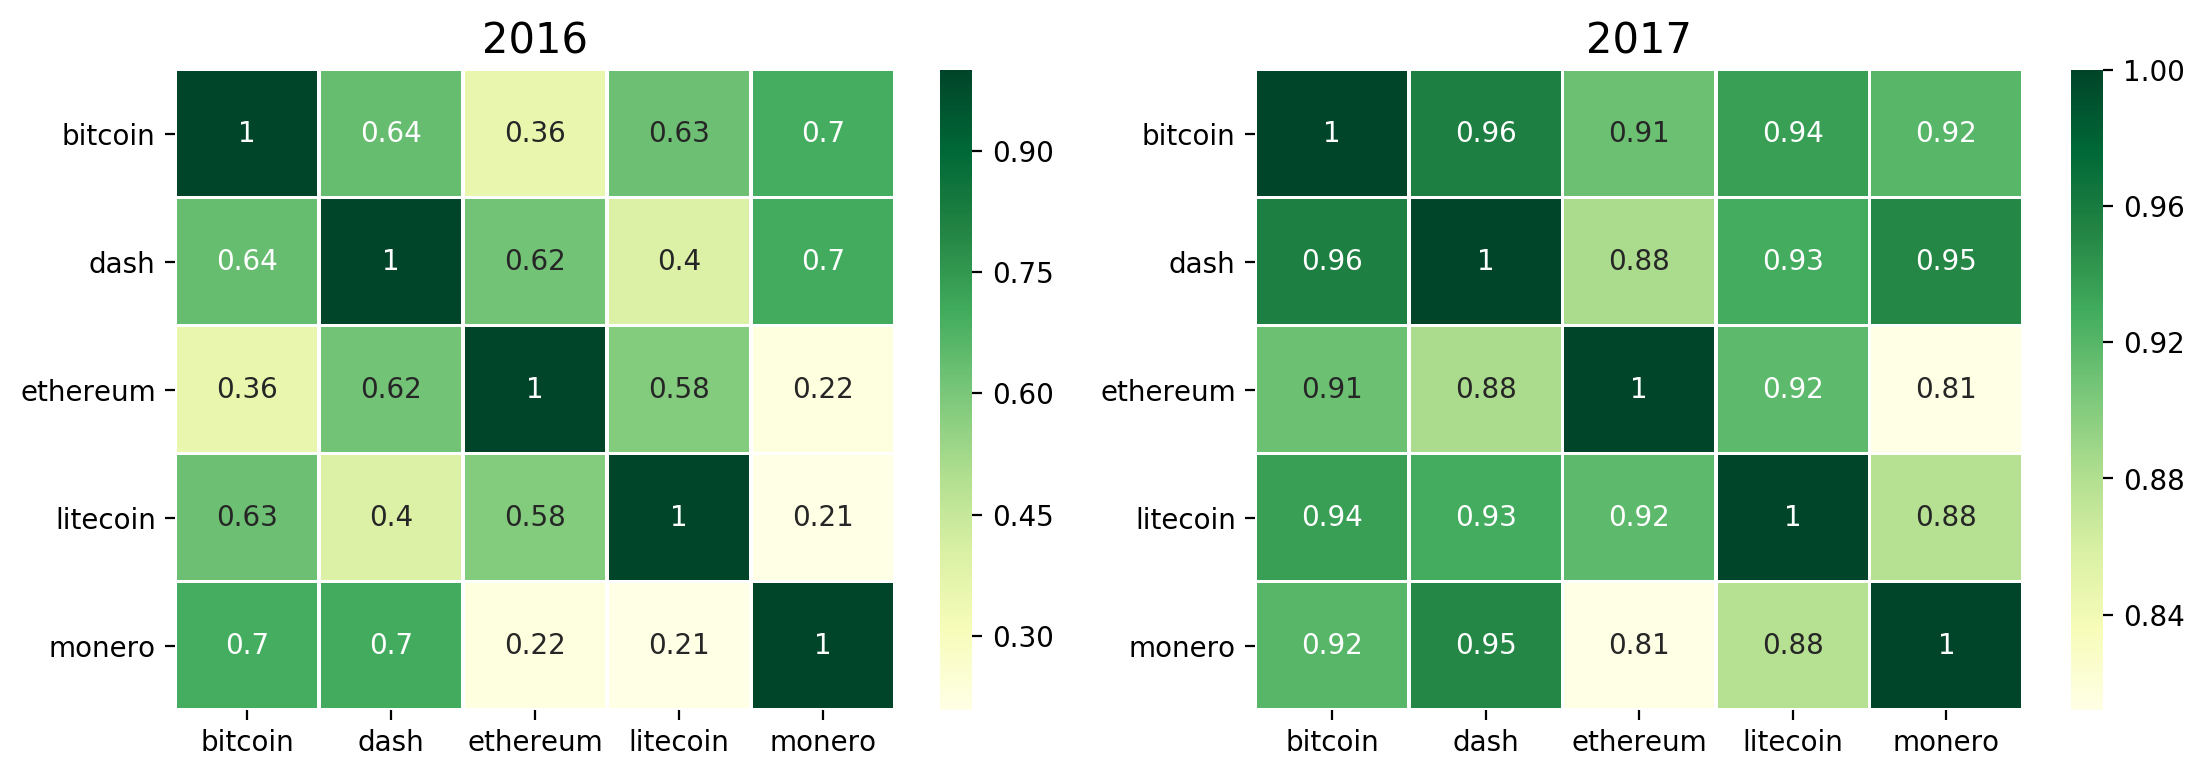

In [8]:
fig = plt.figure(dpi = 200)

axes1 = fig.add_axes([0.1, 0.1, 0.75, 0.8]) # main axes
sns.heatmap(df_close.ix[df_close.index.year == 2016].corr(method='pearson'), lw = 1, linecolor='white', annot = True, cmap = 'YlGn')
axes1.set_title("2016", fontsize=15)

axes2 = fig.add_axes([1, 0.1, 0.8, 0.8]) # inset axes
sns.heatmap(df_close.ix[df_close.index.year == 2017].corr(method='pearson'), lw = 1, linecolor='white', annot = True, cmap = 'YlGn')
plt.title("2017", fontsize=15)

What does this chart tell us? Essentially, it shows that there was little statistically significant linkage between how the prices of different cryptocurrencies fluctuated during 2016. 

Why this difference in correlation in 2016 and 2017? 

The most immediate explanation that comes to mind is that hedge funds have recently begun publicly trading in crypto-currency markets. These funds have vastly more capital to play with than the average trader, so if a fund is hedging their bets across multiple cryptocurrencies, and using similar trading strategies for each based on independent variables (say, the stock market), it could make sense that this trend of increasing correlations would emerge.

We can also observe this visually by plotting a pair plot for the year 2017 using the seaborn libraries.

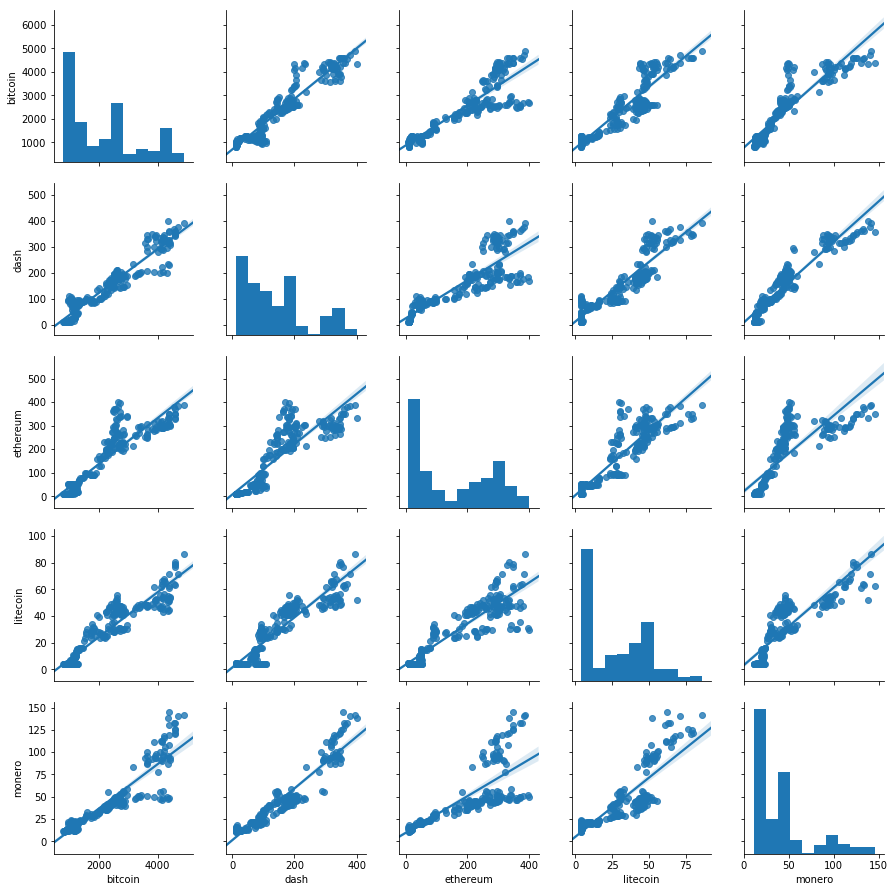

In [9]:
sns.pairplot(df_close[df_close.index.year == 2017], kind='reg', palette = 'Y1Gn')

# 4. Stationarity

## 4.1. Function to test stationarity

Let's define a function that takes input as a time series and tells us whether the series is stationary or not, with some more useful information. We calculate the moving variances, plot the results and apply the Dickey-Fuller test on the time series.

In [10]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6), dpi = 200)
    axes1 = fig.add_axes([0.1, 0.1, 0.75, 0.8]) # main axes
    axes1.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    axes1.plot(rolmean.index.to_pydatetime(), rolmean.values, color='red', label='Rolling Mean')
    axes1.plot(rolstd.index.to_pydatetime(), rolstd.values, color='black', label = 'Rolling Std')
    axes1.set_title('Rolling Mean and Standard Deviation')
    plt.legend(loc = 'best')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## 4.2. Stationary tests on top 3 cryptocurrencies

bitcoin


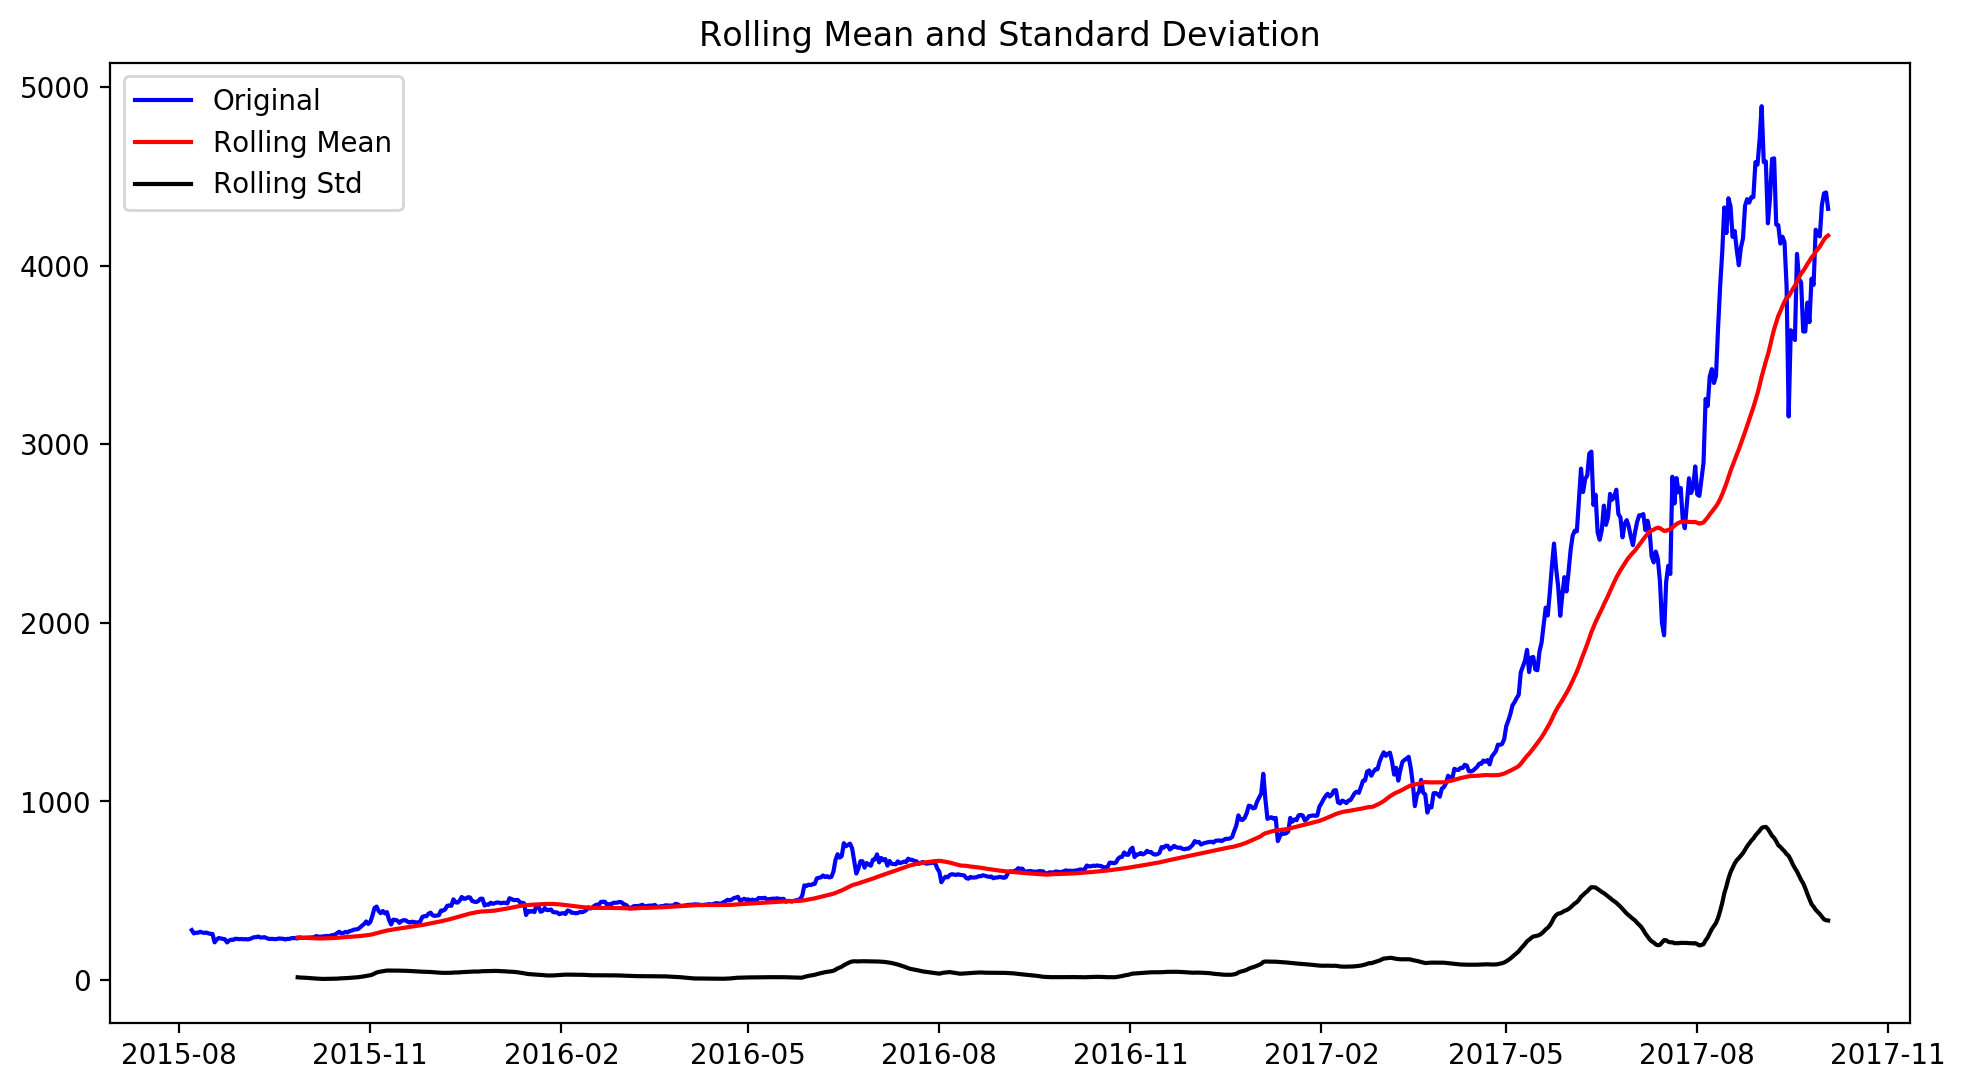

Results of Dickey-Fuller Test:
Test Statistic                   1.735309
p-value                          0.998212
#Lags Used                      21.000000
Number of Observations Used    767.000000
Critical Value (1%)             -3.438905
Critical Value (5%)             -2.865316
Critical Value (10%)            -2.568781
dtype: float64
ethereum


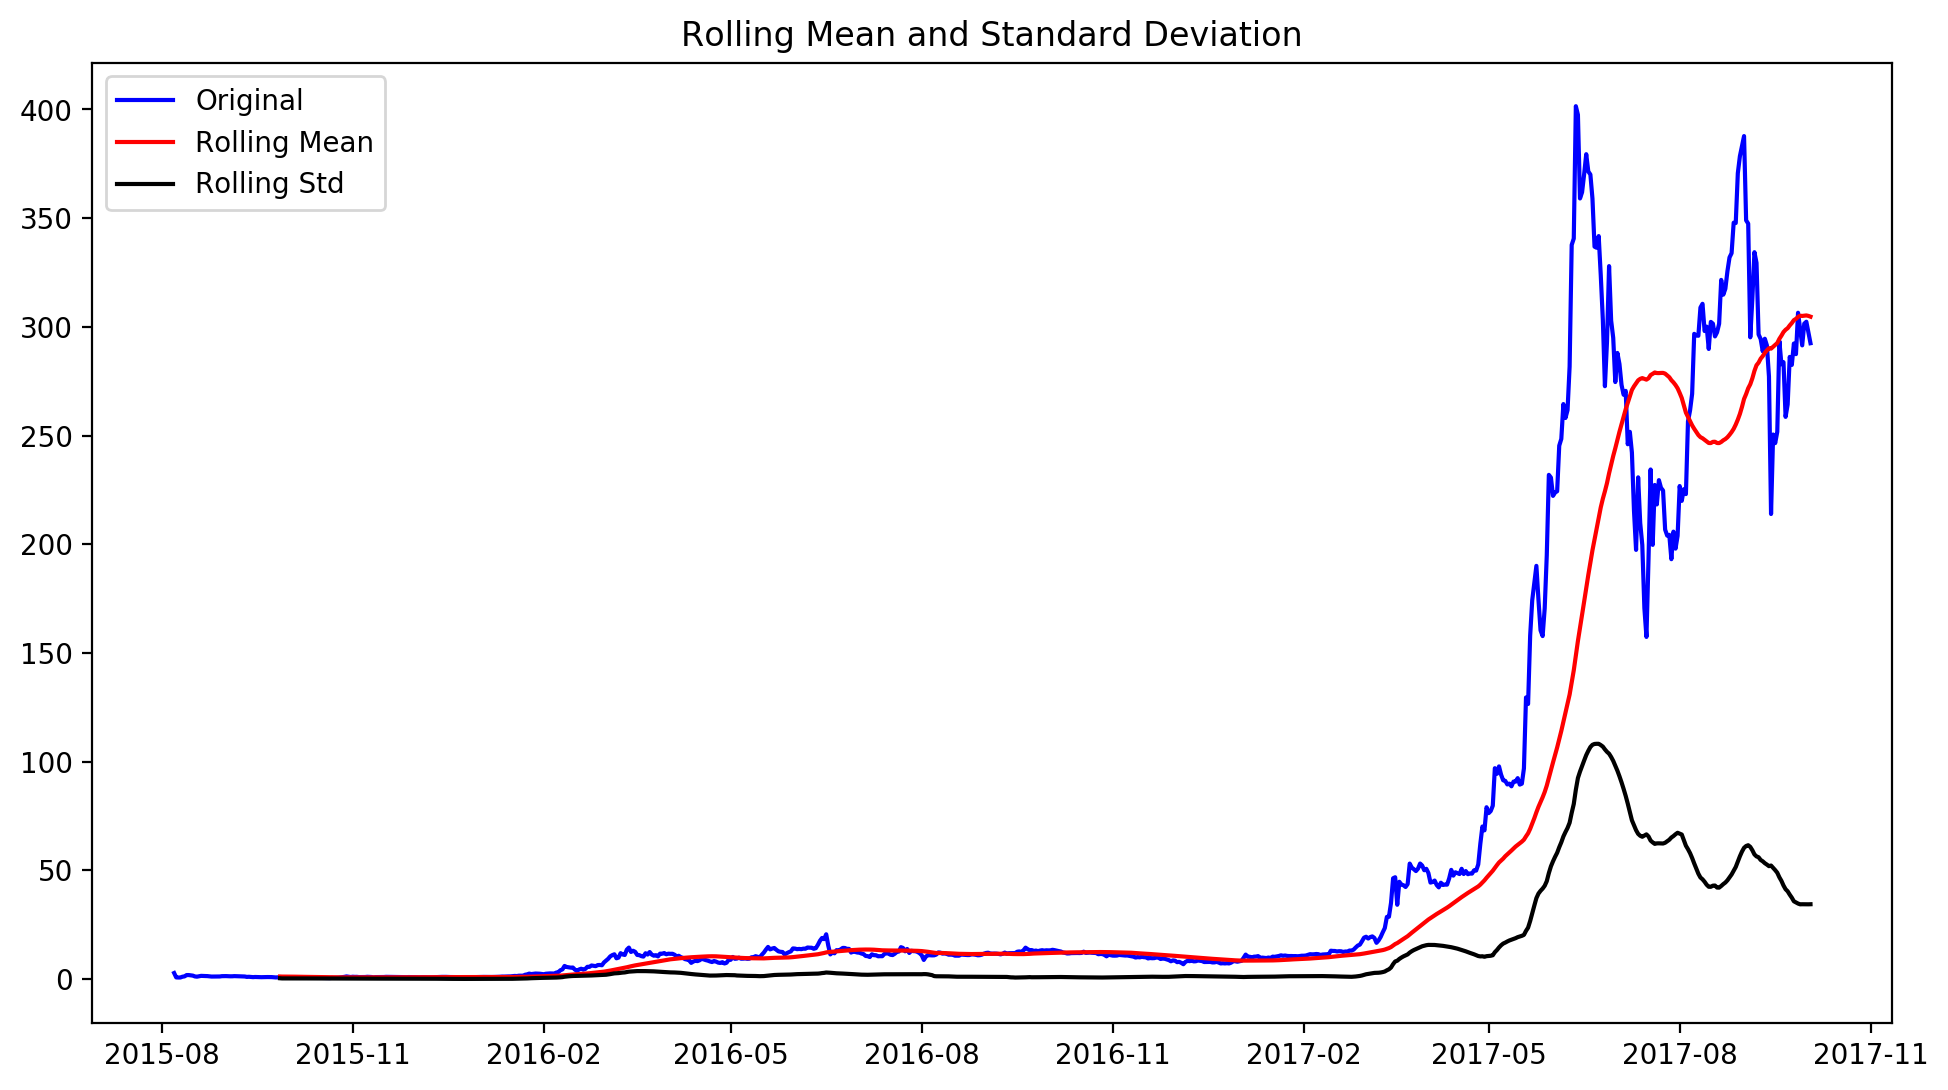

Results of Dickey-Fuller Test:
Test Statistic                  -0.910883
p-value                          0.784368
#Lags Used                      21.000000
Number of Observations Used    767.000000
Critical Value (1%)             -3.438905
Critical Value (5%)             -2.865316
Critical Value (10%)            -2.568781
dtype: float64
litecoin


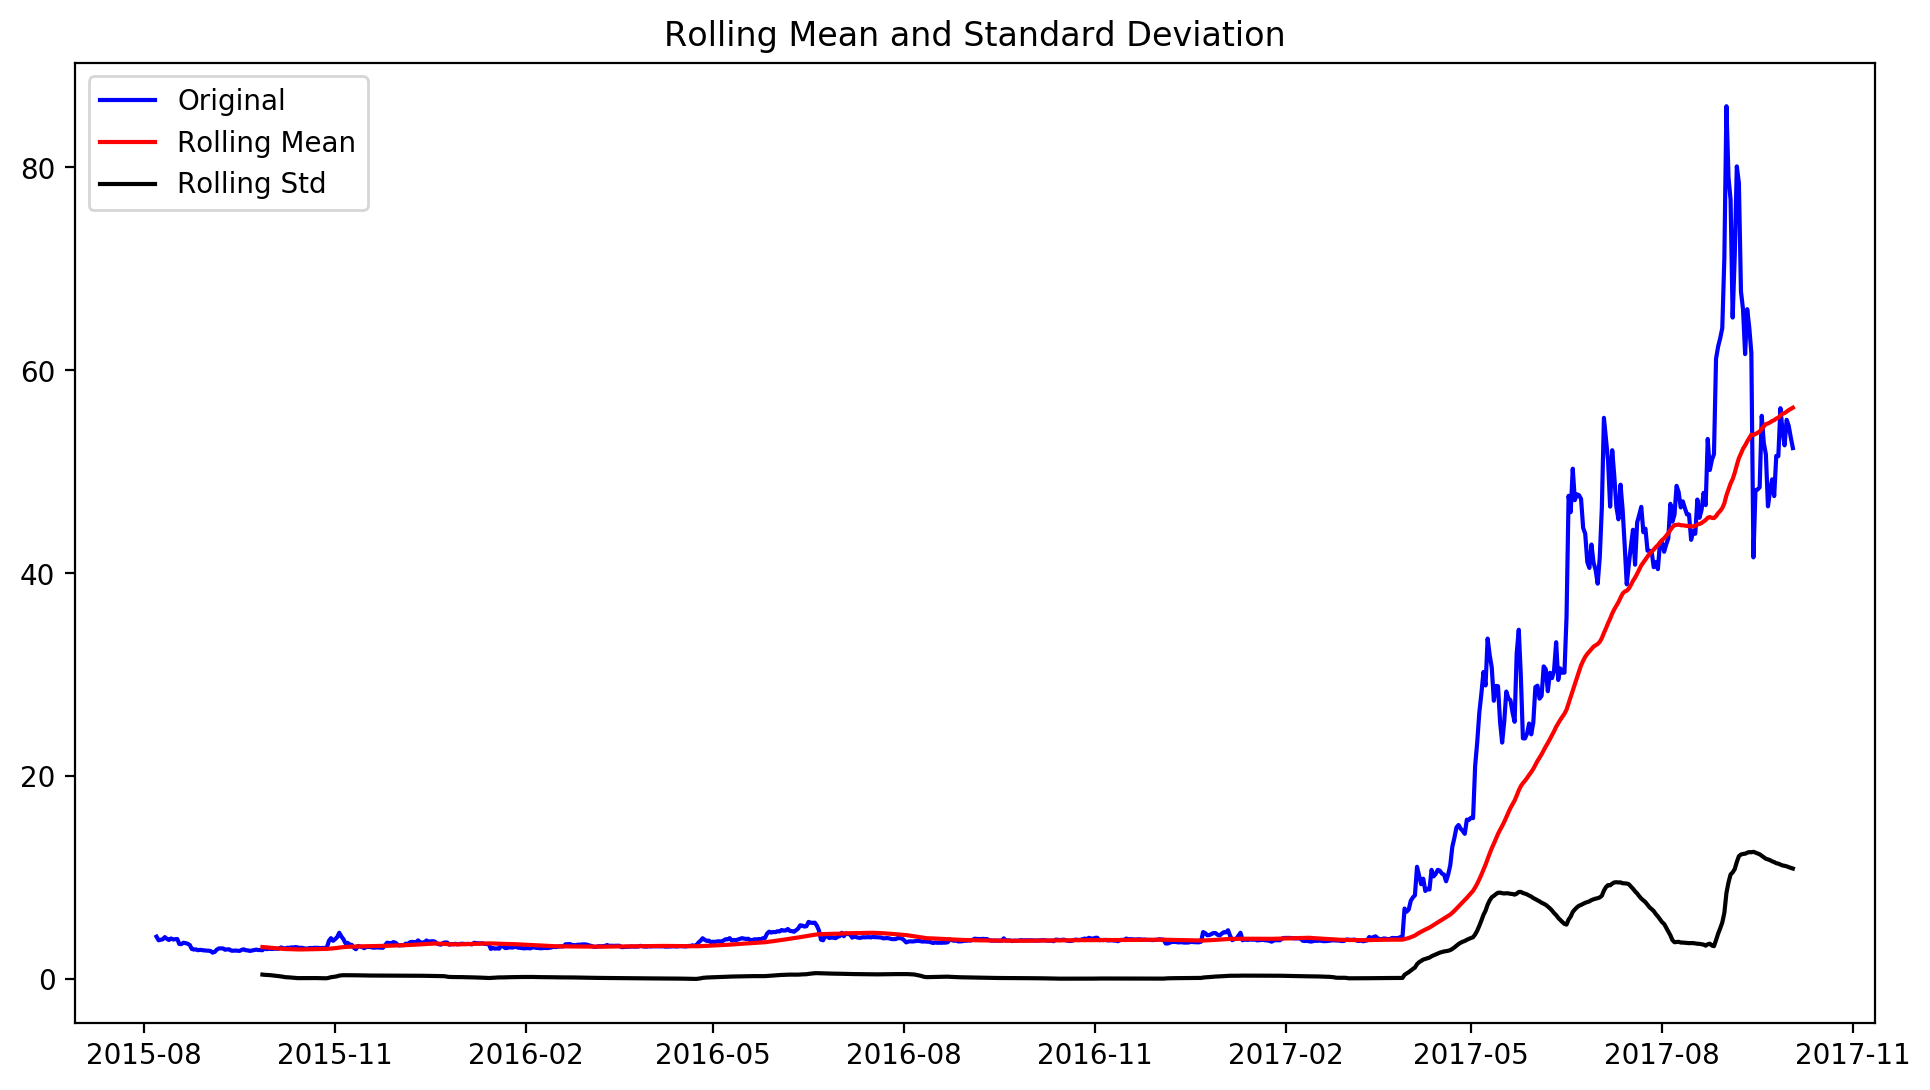

Results of Dickey-Fuller Test:
Test Statistic                   0.857718
p-value                          0.992513
#Lags Used                      21.000000
Number of Observations Used    767.000000
Critical Value (1%)             -3.438905
Critical Value (5%)             -2.865316
Critical Value (10%)            -2.568781
dtype: float64


In [11]:
# create a dataframe with top 3 cryptocurrencies
df_3_close = df_close['bitcoin ethereum litecoin'.split()]

for col in df_3_close.columns:
    print(col)
    test_stationarity(df_3_close[col])

We can see that none of the cryptocurrency data is stationary, as indicated by Dickey-Fuller Test. Also, the data shows trend. 

One of the most common methods of dealing with both trend is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity.

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values and this can be taking a log. 

## 4.3. Apply log transform

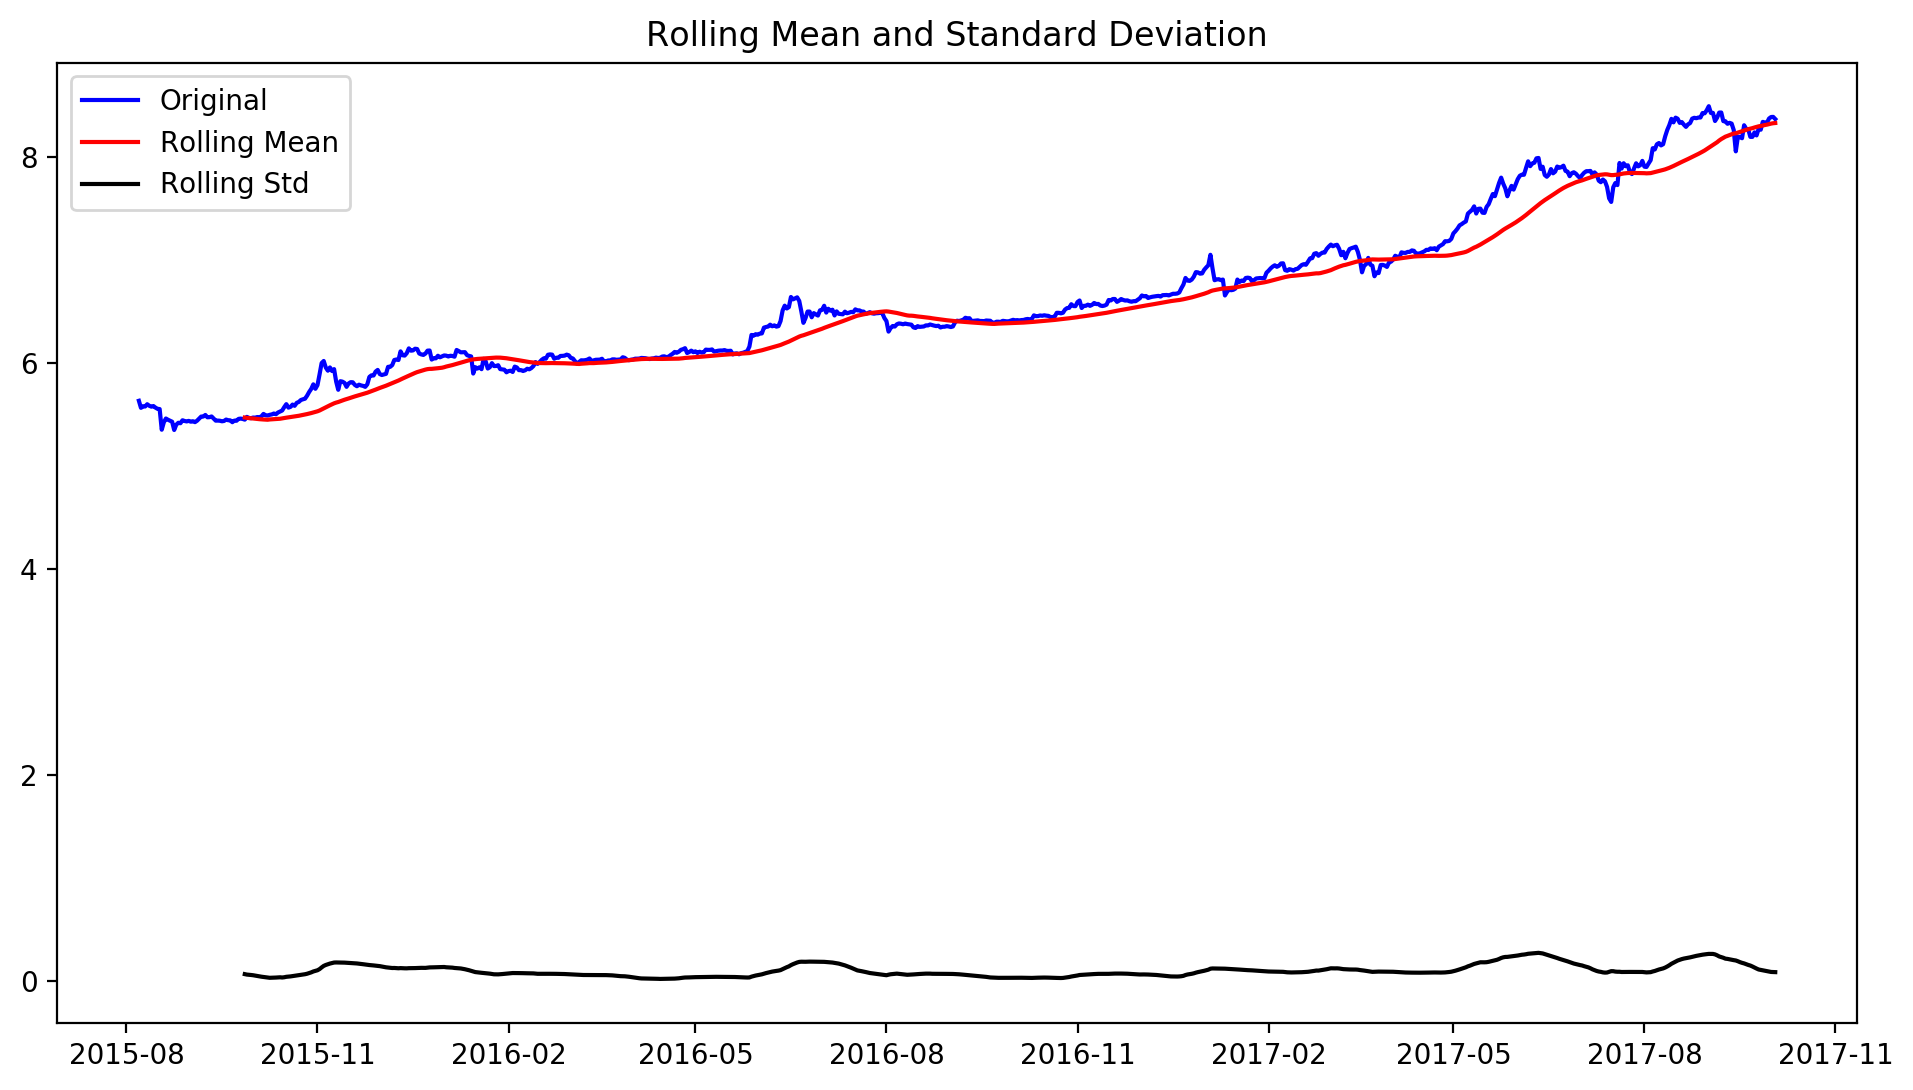

Results of Dickey-Fuller Test:
Test Statistic                   0.672156
p-value                          0.989265
#Lags Used                       0.000000
Number of Observations Used    788.000000
Critical Value (1%)             -3.438676
Critical Value (5%)             -2.865215
Critical Value (10%)            -2.568727
dtype: float64


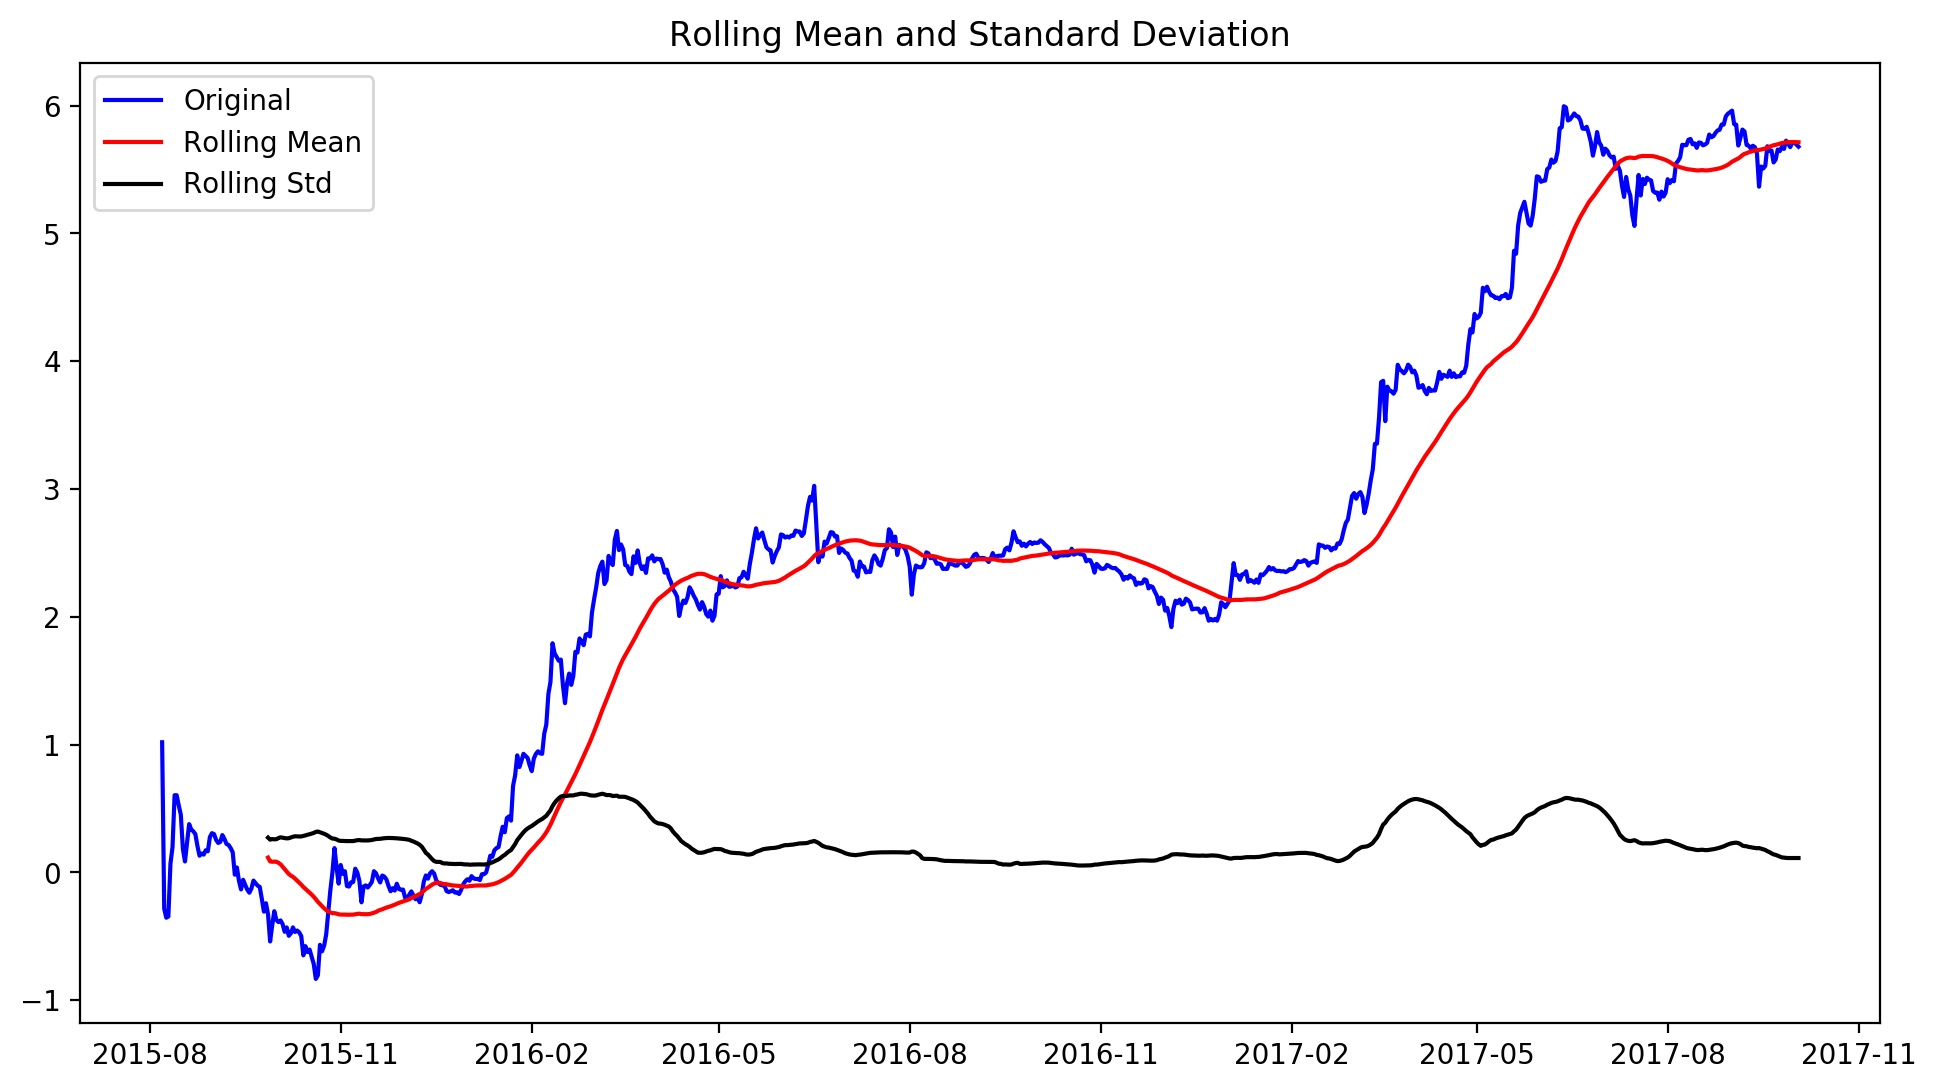

Results of Dickey-Fuller Test:
Test Statistic                  -0.325383
p-value                          0.921832
#Lags Used                       3.000000
Number of Observations Used    785.000000
Critical Value (1%)             -3.438708
Critical Value (5%)             -2.865229
Critical Value (10%)            -2.568734
dtype: float64


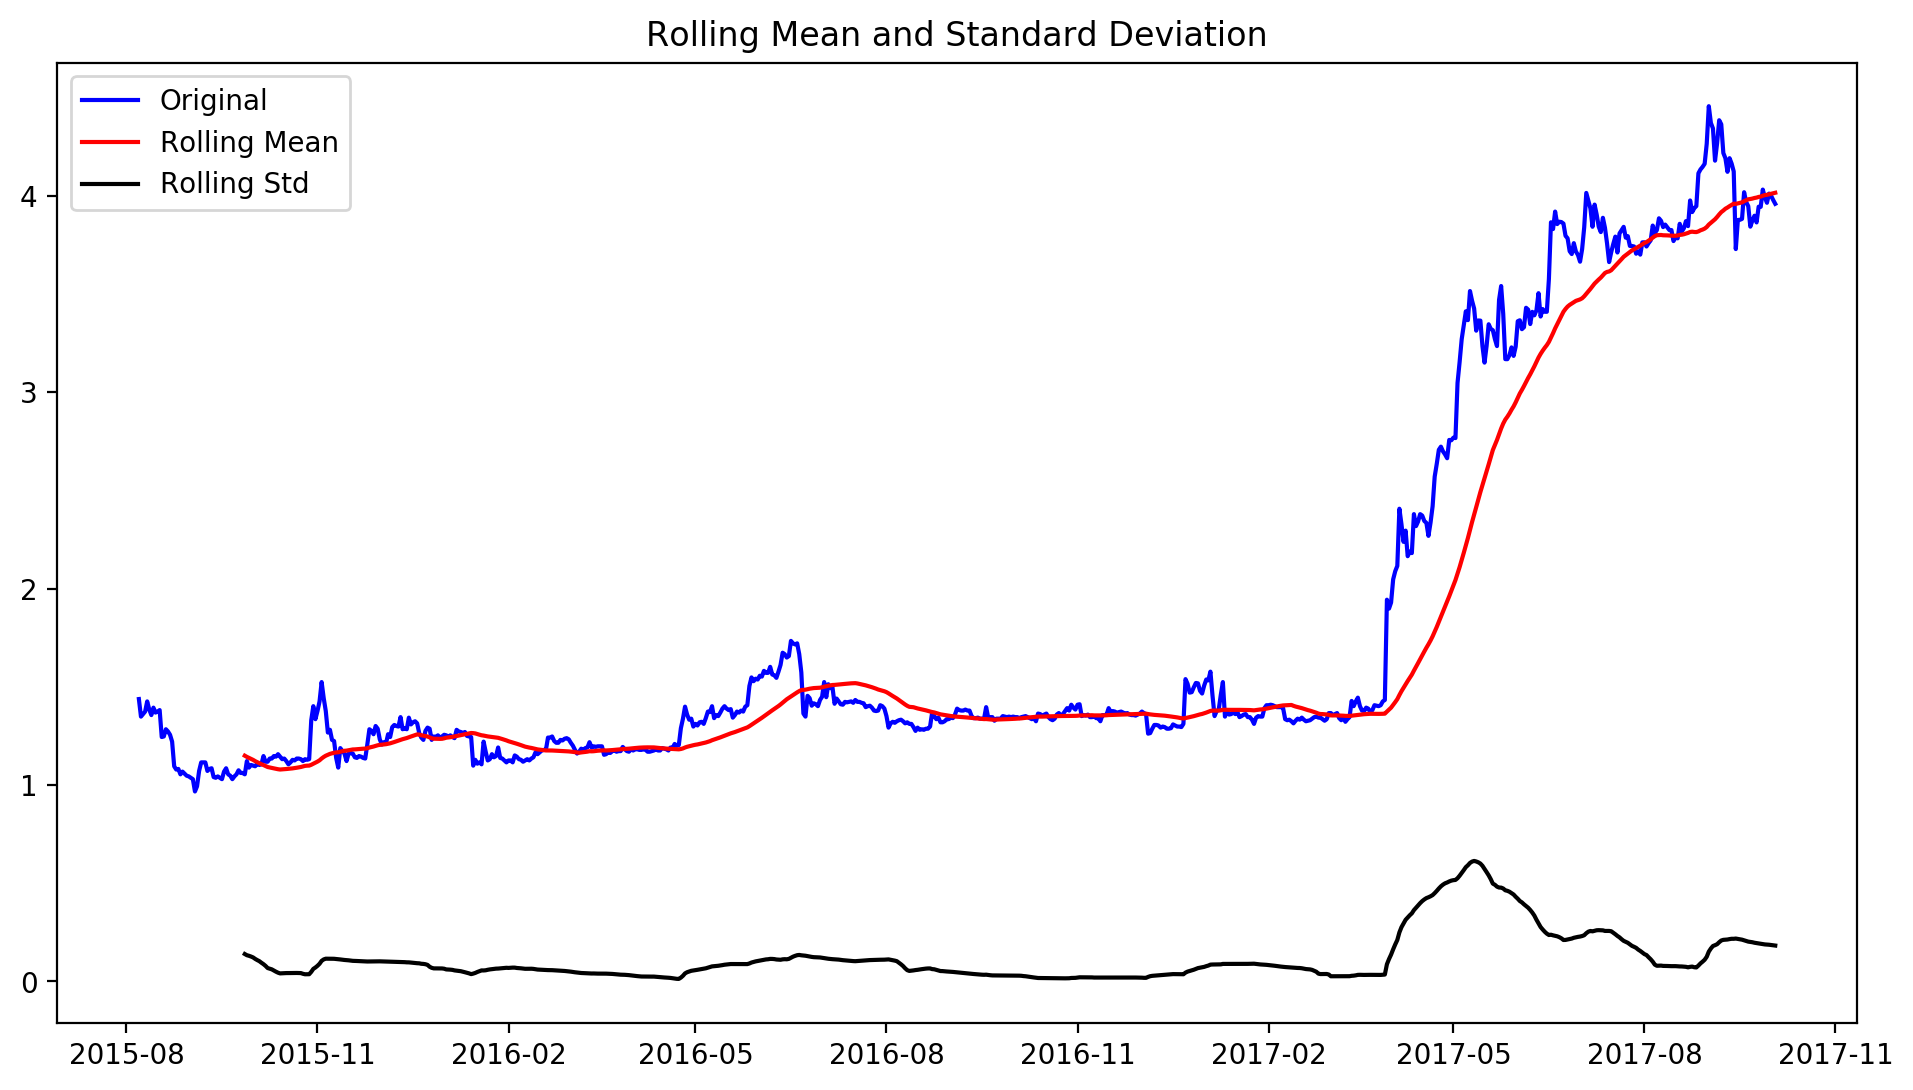

Results of Dickey-Fuller Test:
Test Statistic                   0.862111
p-value                          0.992575
#Lags Used                       8.000000
Number of Observations Used    780.000000
Critical Value (1%)             -3.438761
Critical Value (5%)             -2.865253
Critical Value (10%)            -2.568747
dtype: float64


In [12]:
# log of close prices of top 3 cryptocurrencies. 
df_3_close_log = pd.DataFrame()

for col in df_3_close.columns:
    df_3_close_log[col] = np.log(df_3_close[col])
    test_stationarity(df_3_close_log[col])

## 4.4. Apply differencing

Once log operation has been performed, we can see that higher values have been scaled and they are not very high. We can go ahead with differencing.

In [13]:
df_3_close_log_diff = pd.DataFrame()

for col in df_3_close_log:
    df_3_close_log_diff[col] = df_3_close_log[col] - df_3_close_log[col].shift()

df_3_close_log_diff.dropna(inplace=True)
df_3_close_log_diff.iplot()

Let's perform stationarity test for the data obtained after differencing. 

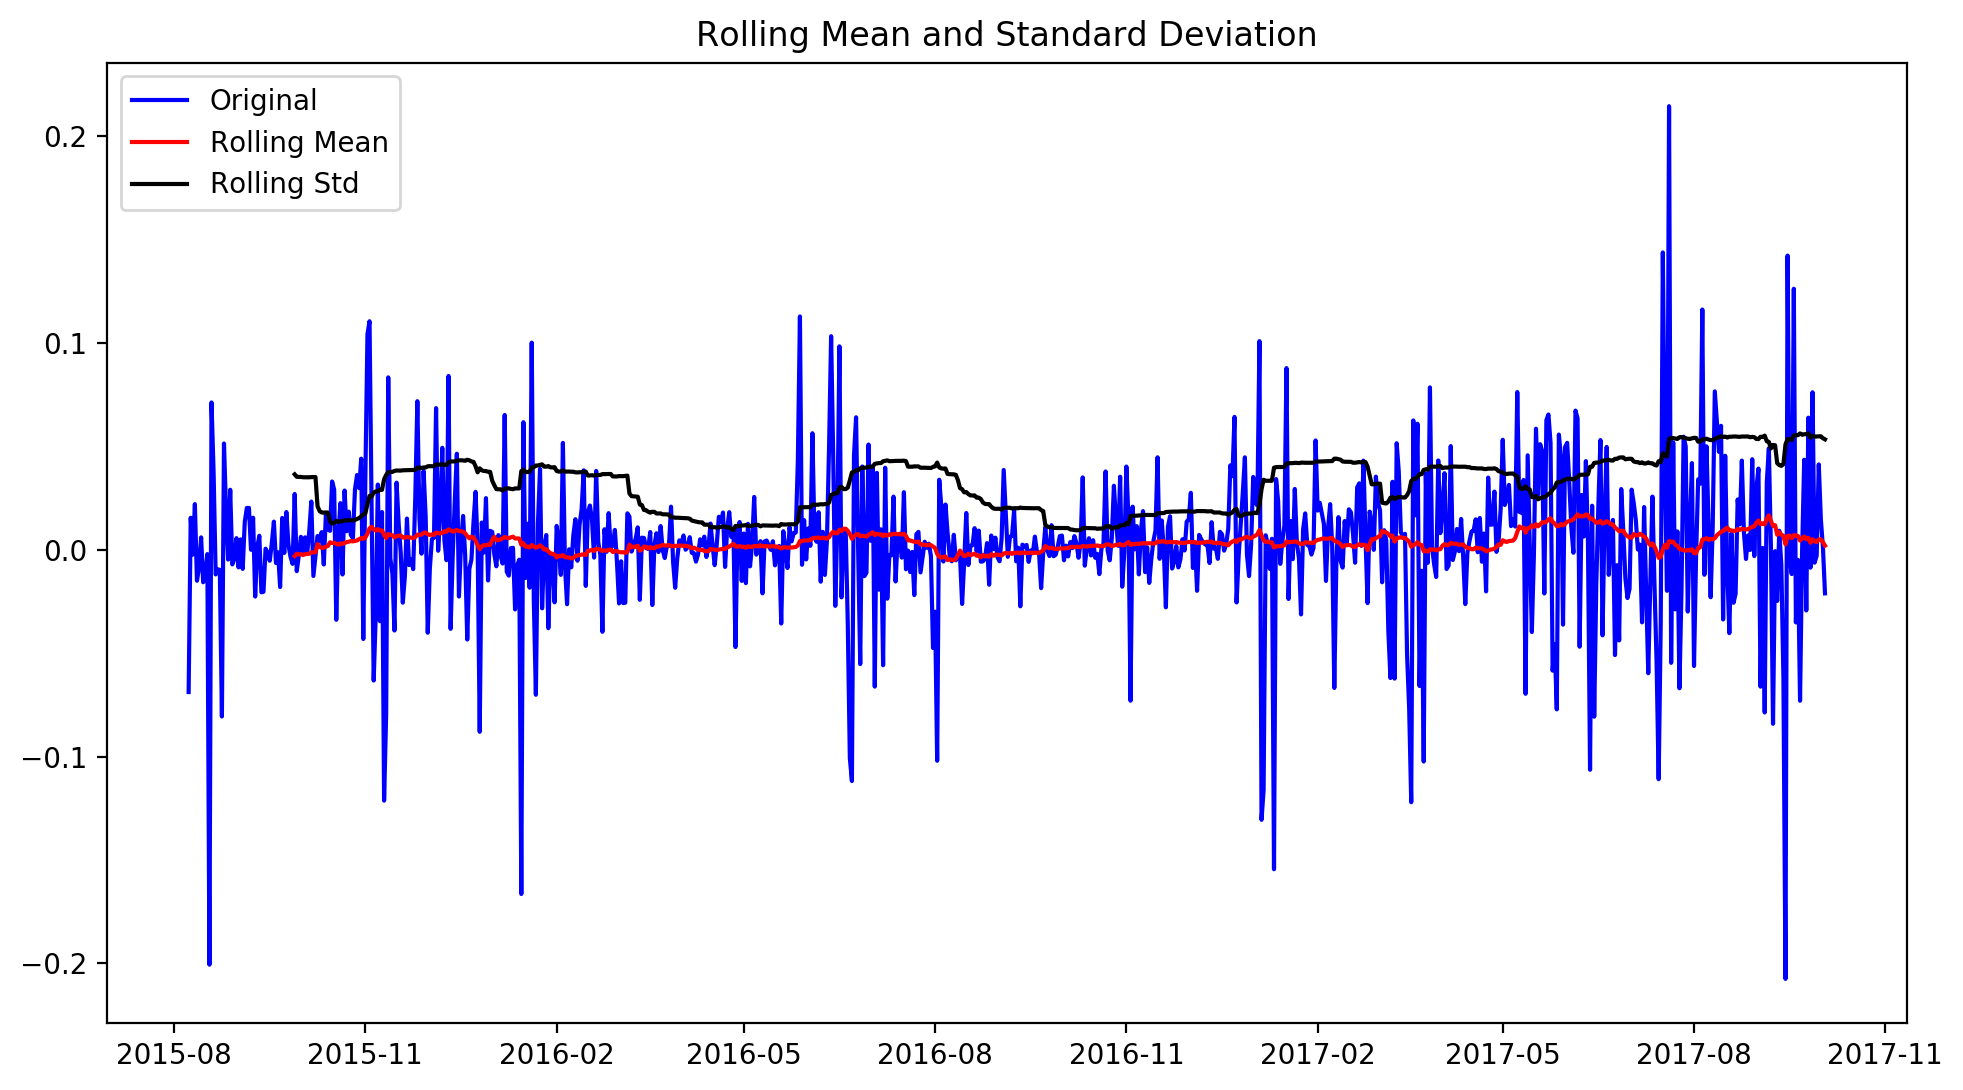

Results of Dickey-Fuller Test:
Test Statistic                 -28.985094
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    787.000000
Critical Value (1%)             -3.438686
Critical Value (5%)             -2.865219
Critical Value (10%)            -2.568729
dtype: float64


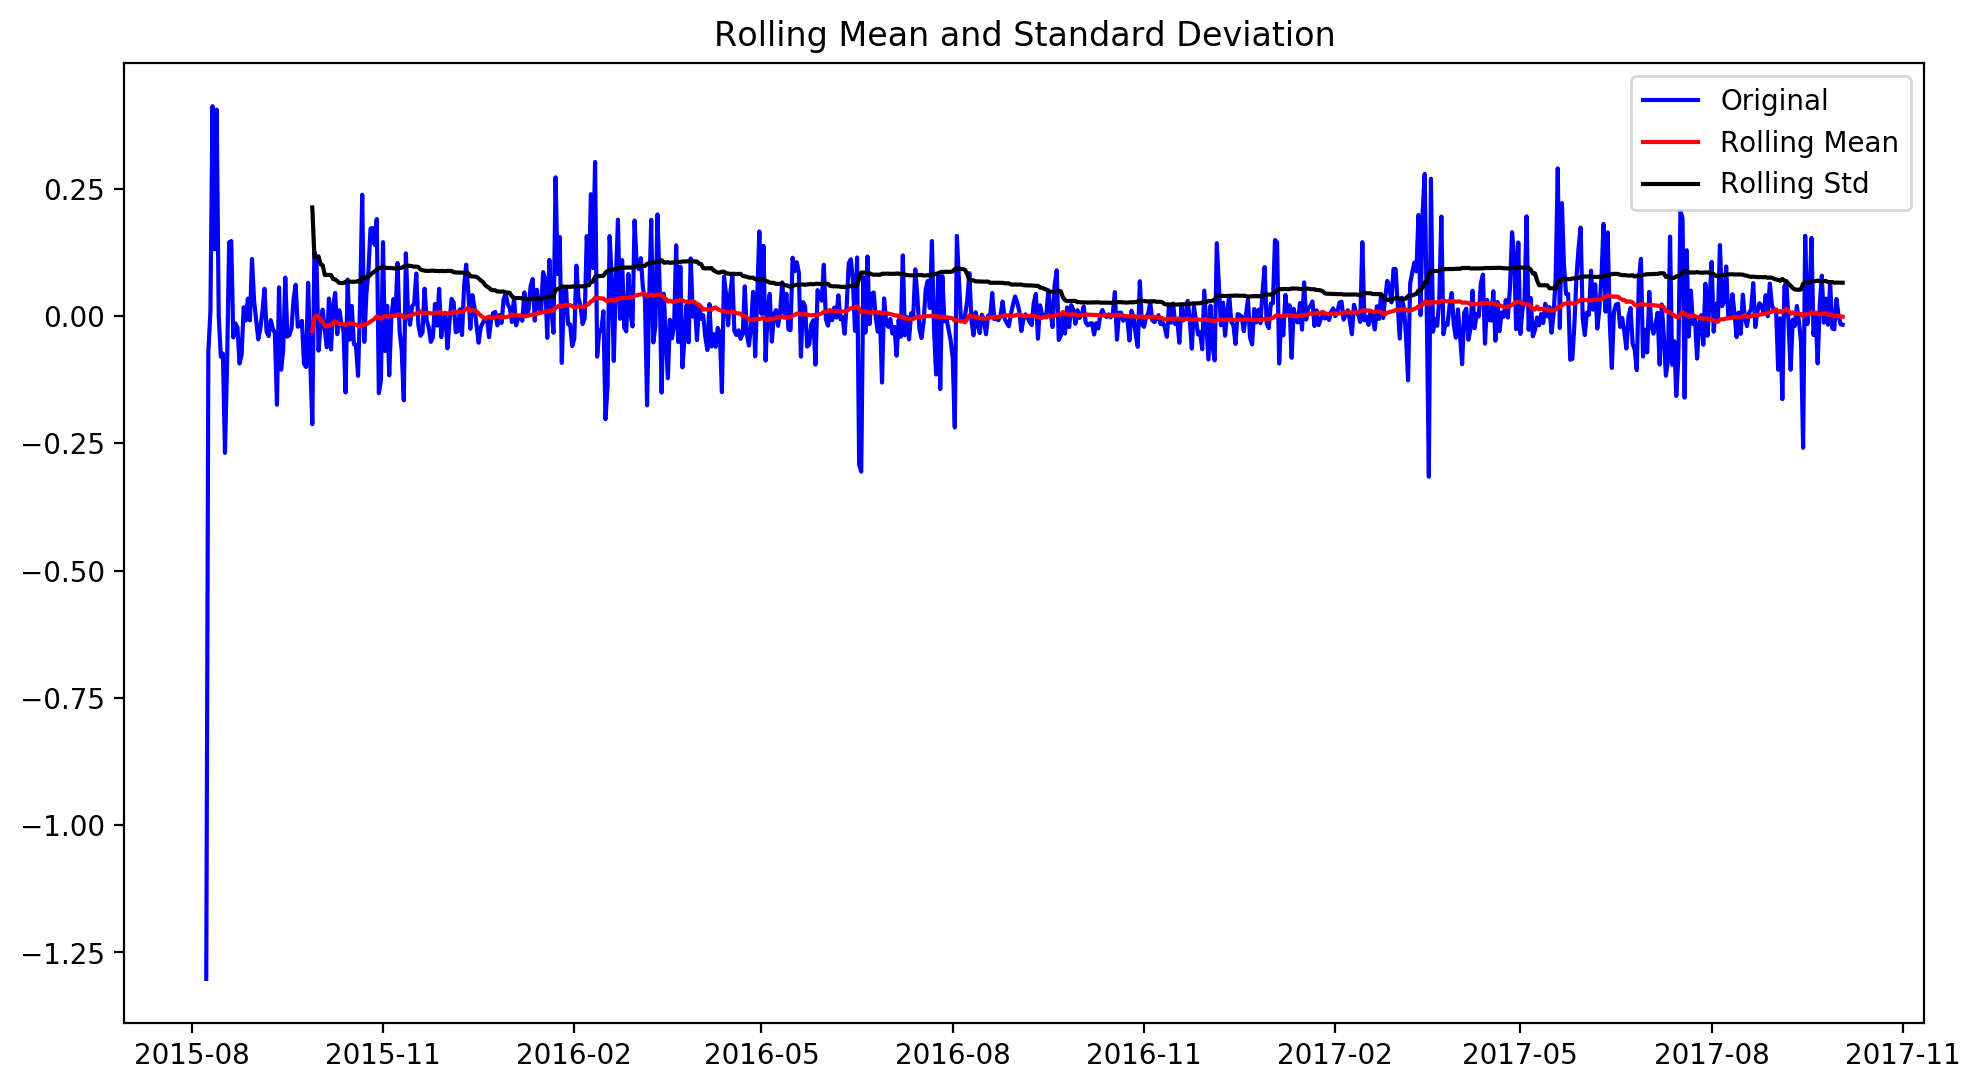

Results of Dickey-Fuller Test:
Test Statistic                -1.727966e+01
p-value                        5.792481e-30
#Lags Used                     2.000000e+00
Number of Observations Used    7.850000e+02
Critical Value (1%)           -3.438708e+00
Critical Value (5%)           -2.865229e+00
Critical Value (10%)          -2.568734e+00
dtype: float64


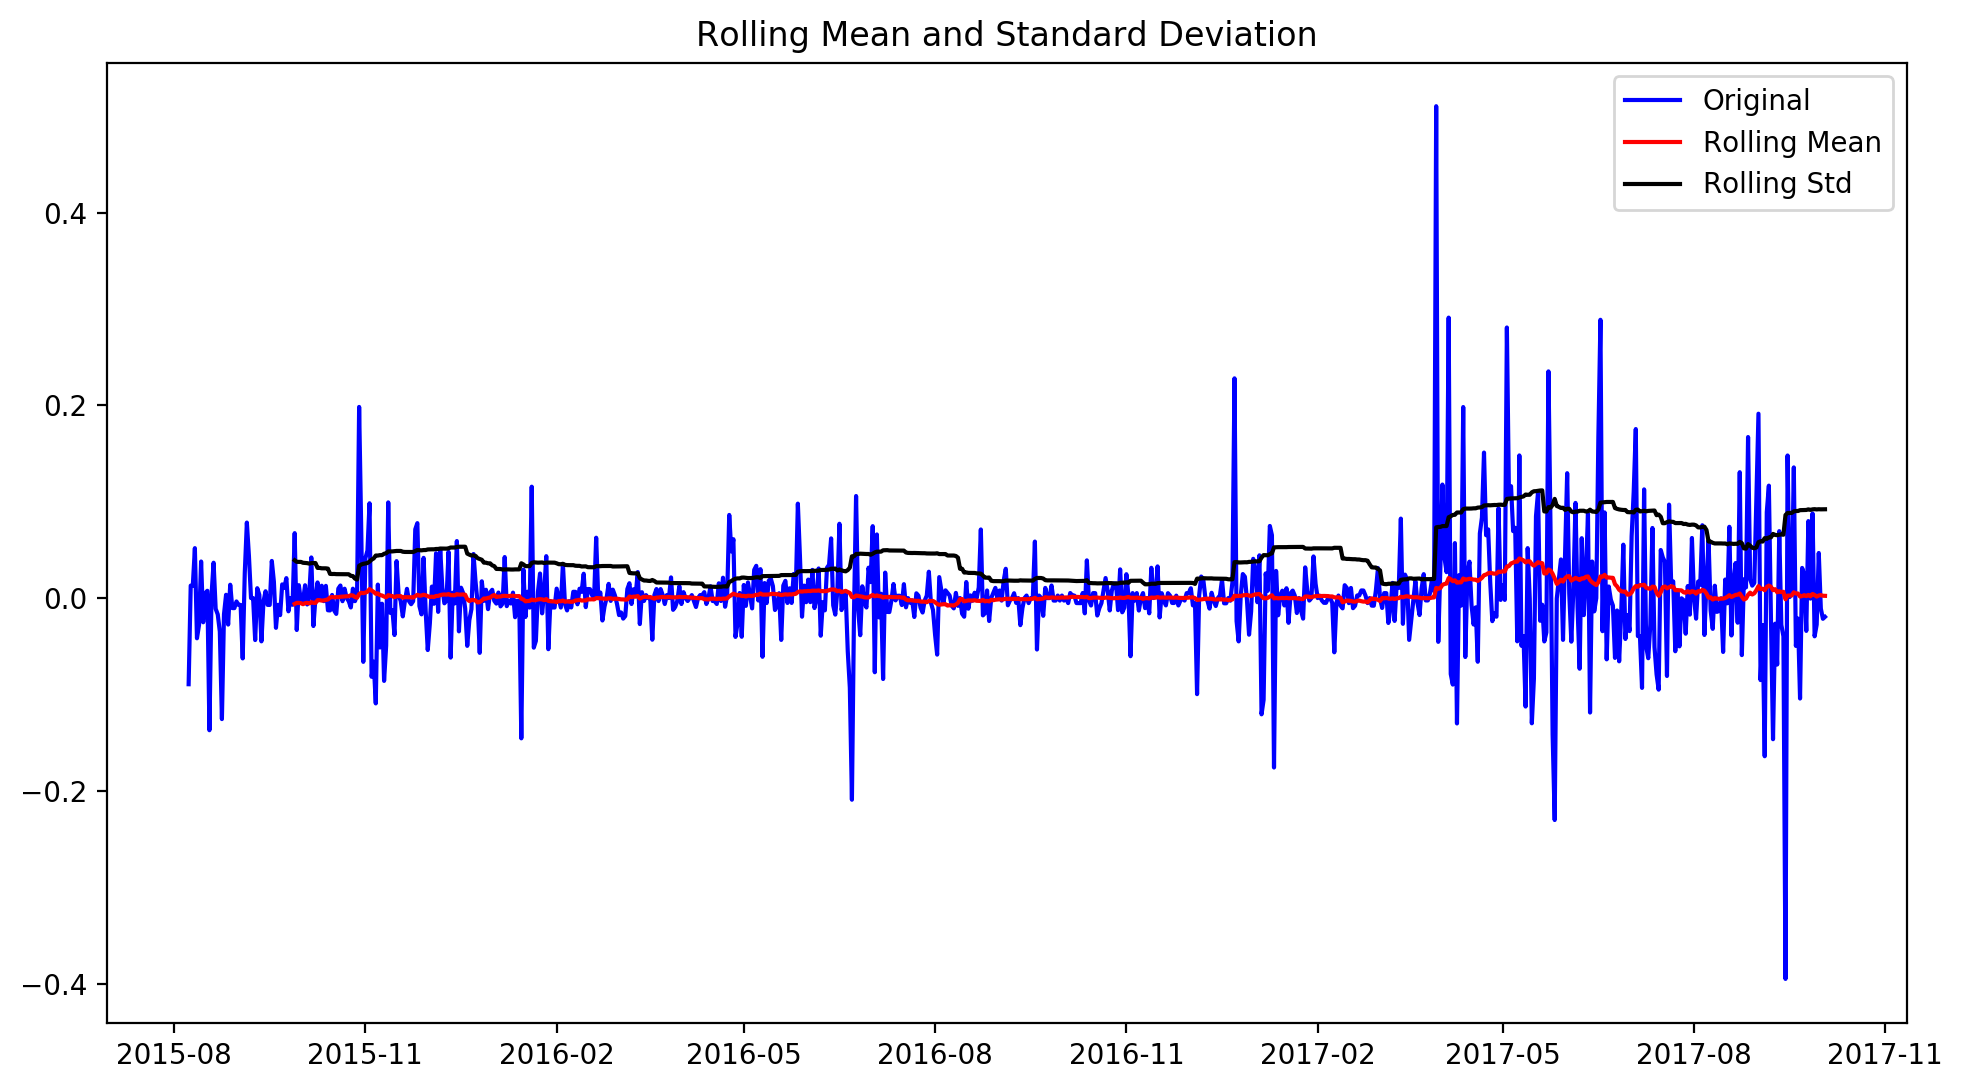

Results of Dickey-Fuller Test:
Test Statistic                -1.051735e+01
p-value                        9.885420e-19
#Lags Used                     7.000000e+00
Number of Observations Used    7.800000e+02
Critical Value (1%)           -3.438761e+00
Critical Value (5%)           -2.865253e+00
Critical Value (10%)          -2.568747e+00
dtype: float64


In [14]:
# stationarity test for data after differencing
for col in df_3_close_log_diff:
    test_stationarity(df_3_close_log_diff[col])

Now we can see that the data has become stationary, also as indicated by the Dickey-Fuller test. 

# 5. ARIMA Model

## 5.1. ACF and PACF plots

bitcoin


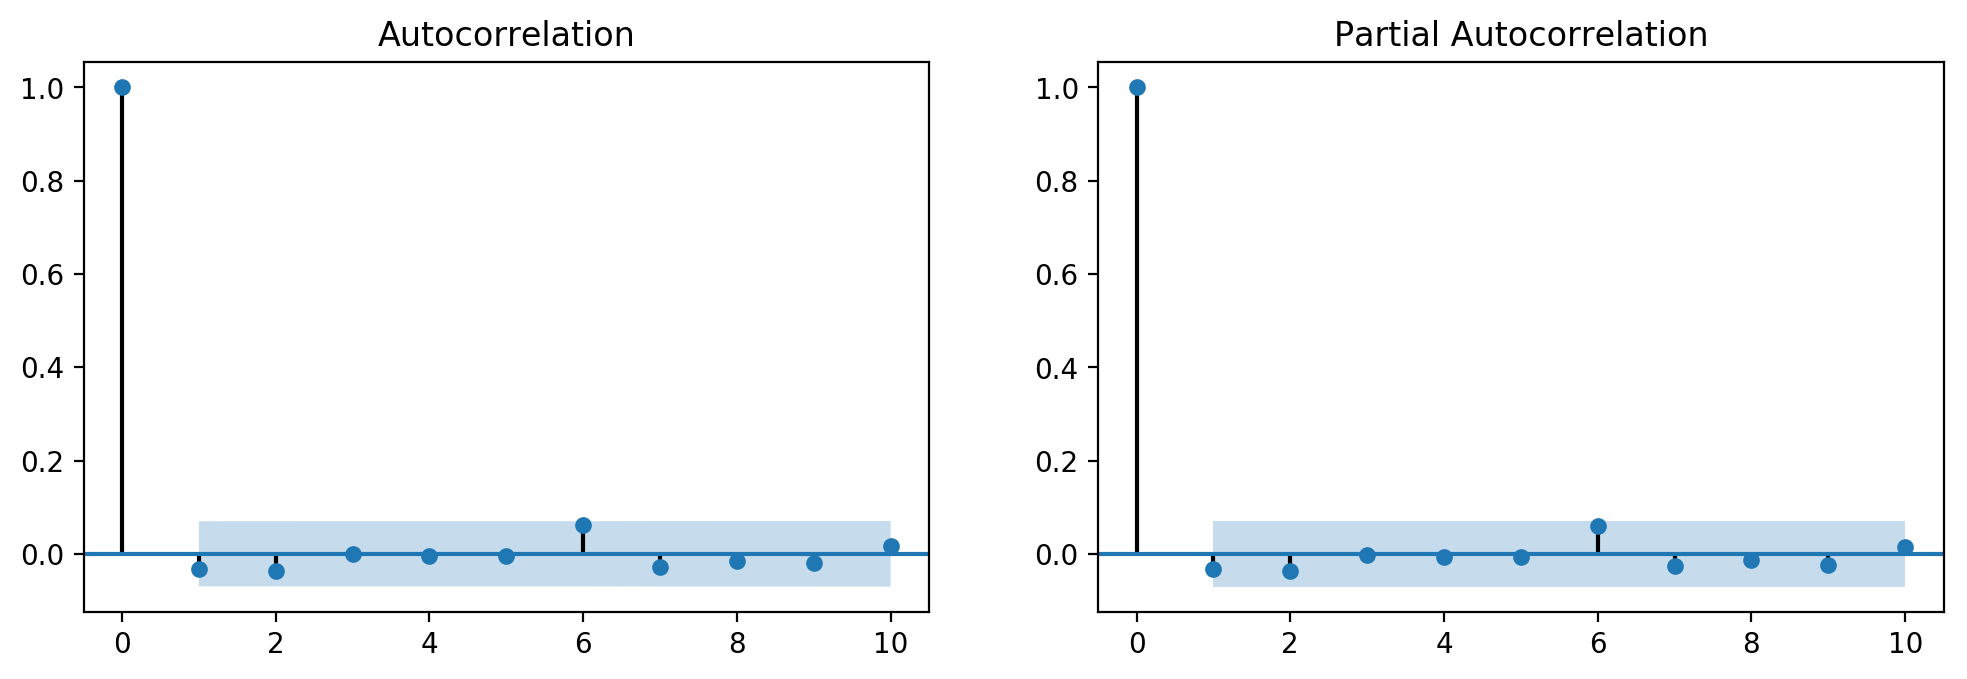

ethereum


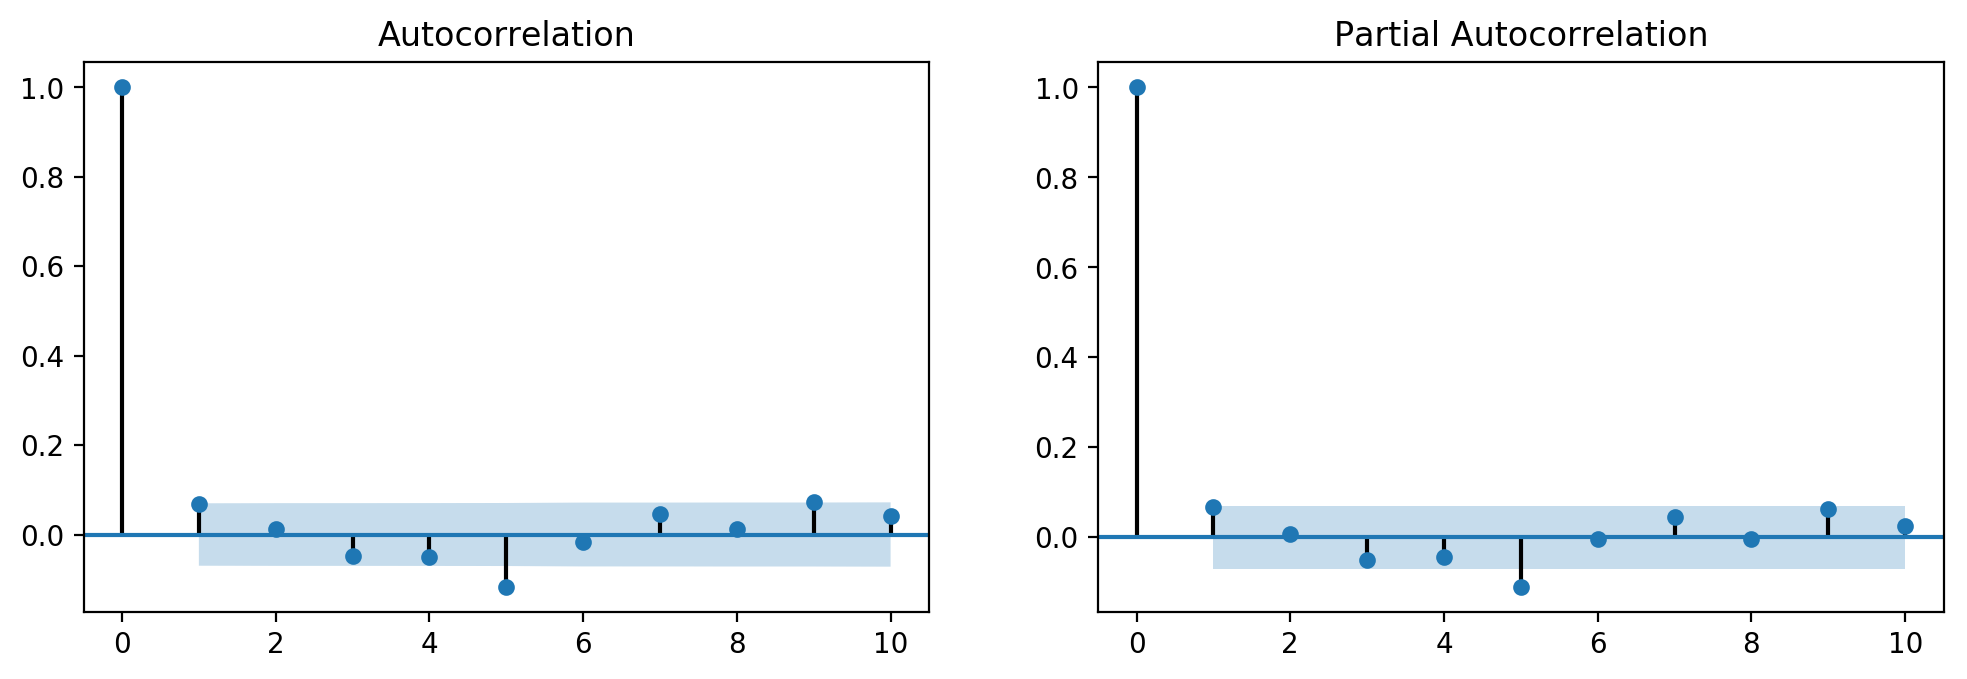

litecoin


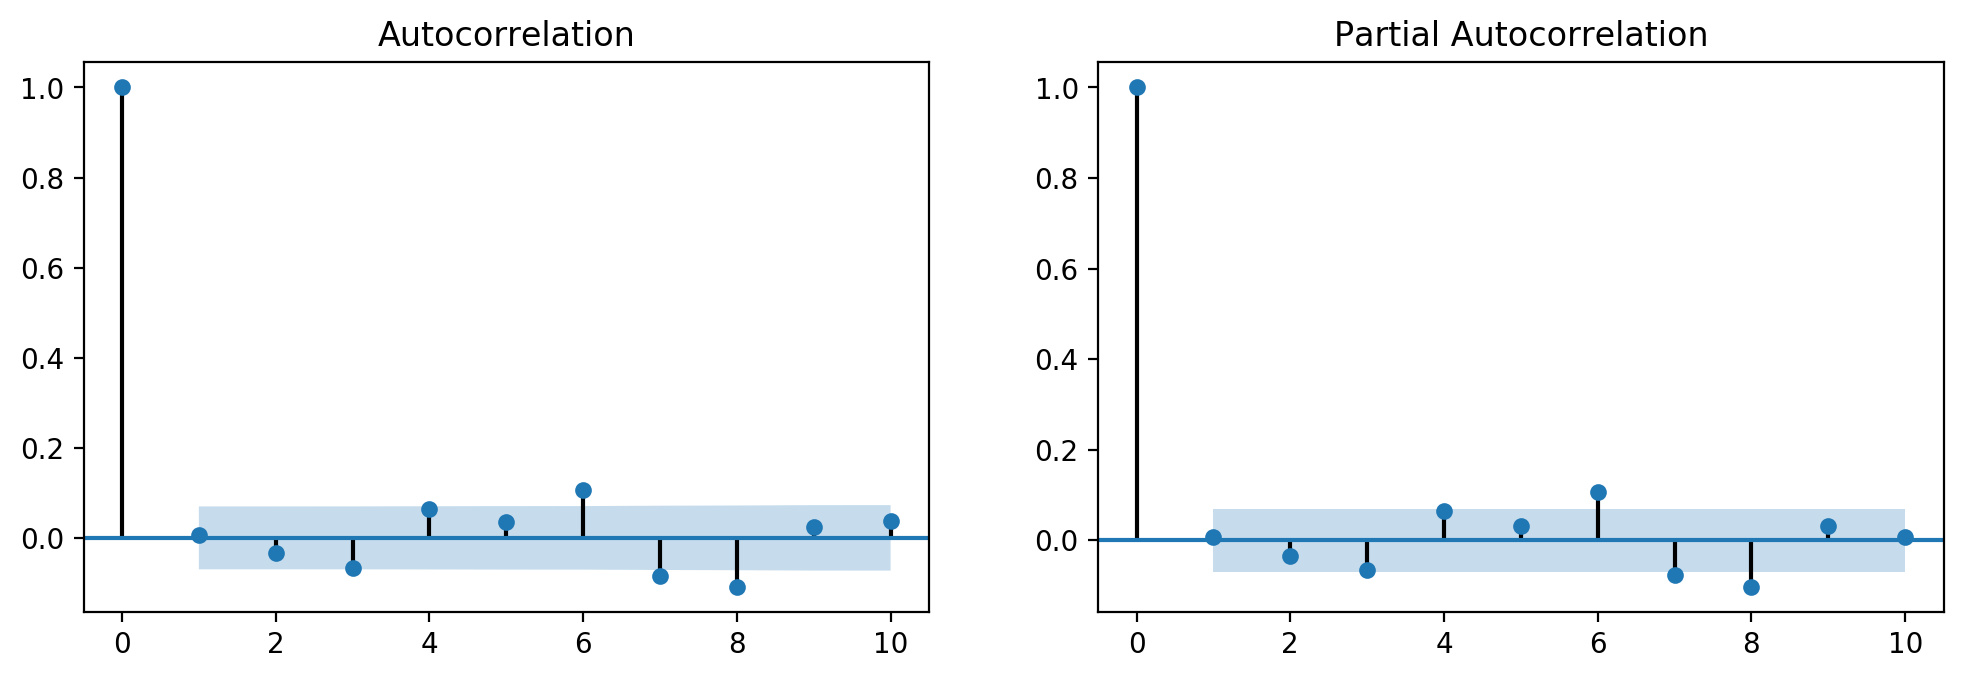

In [15]:
for col in df_3_close_log_diff:
    print(col)
    fig = plt.figure(figsize=(12,8), dpi = 200)
    ax1 = fig.add_subplot(221)
    fig = plot_acf(df_3_close_log_diff[col], lags=10, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = plot_pacf(df_3_close_log_diff[col], lags=10, ax=ax2)
    plt.show()

##  5.2. Building the Model

bitcoin


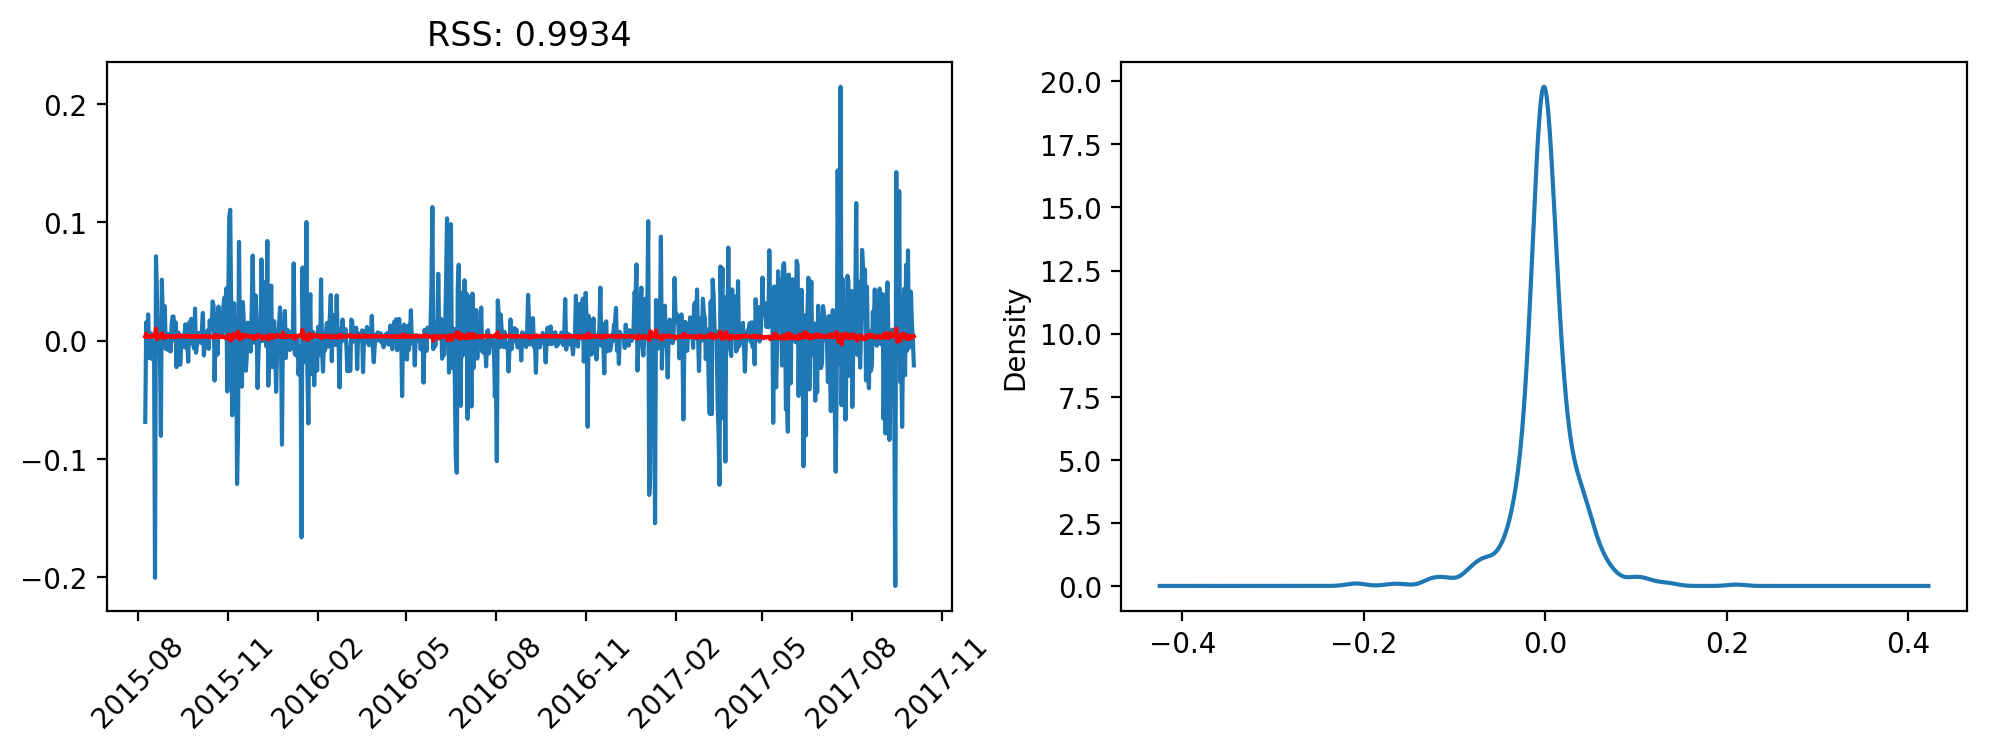

ethereum


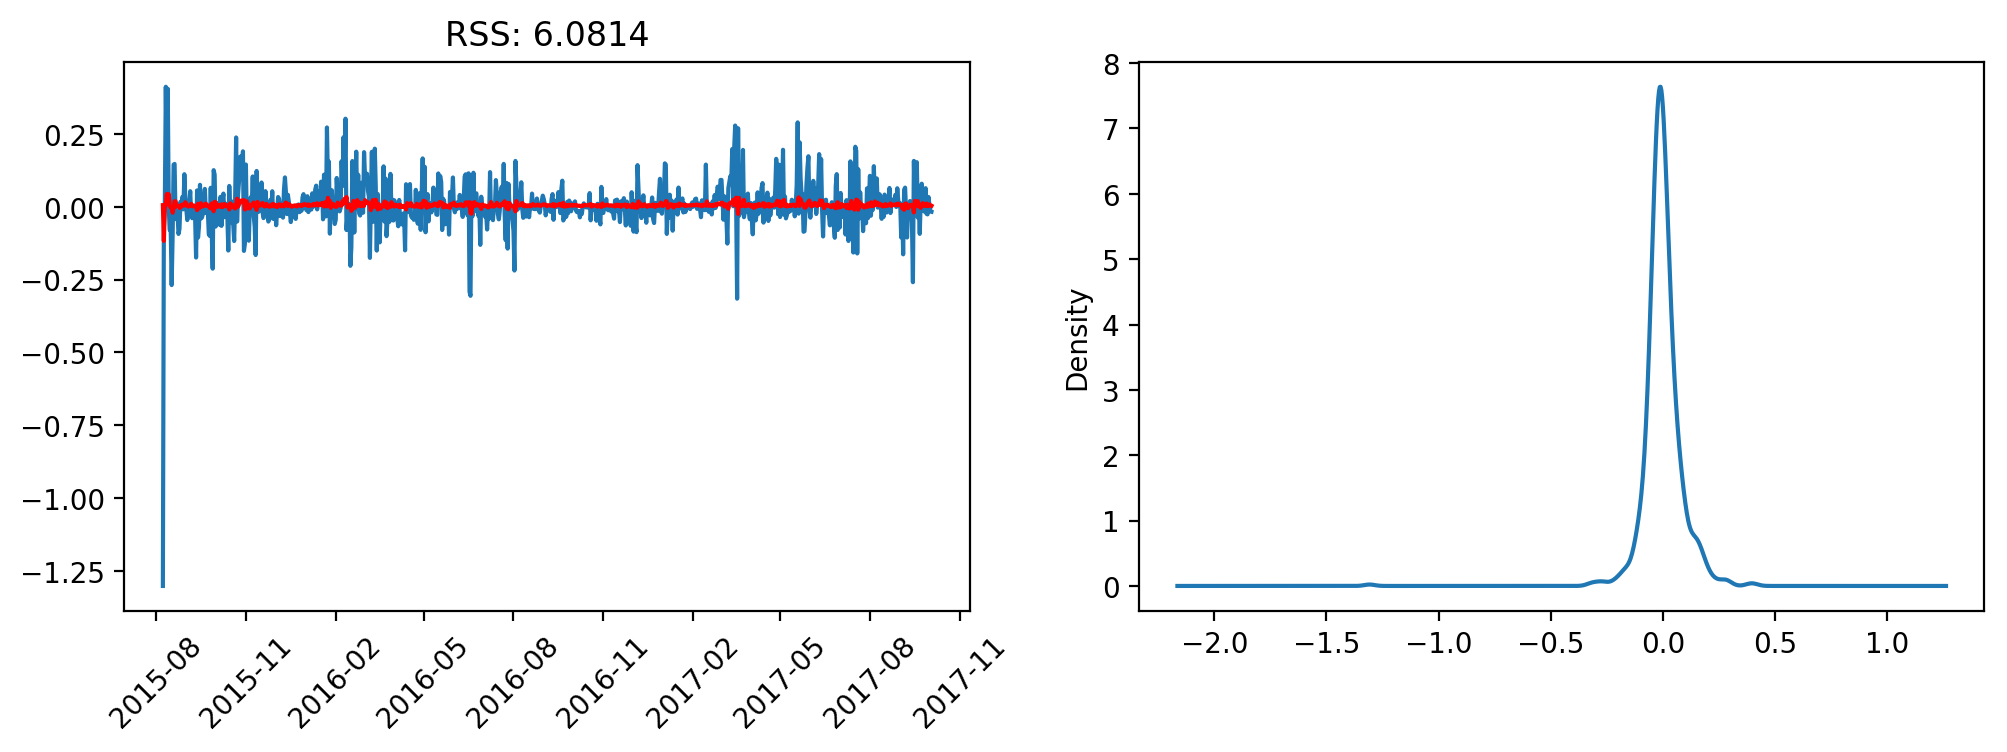

litecoin


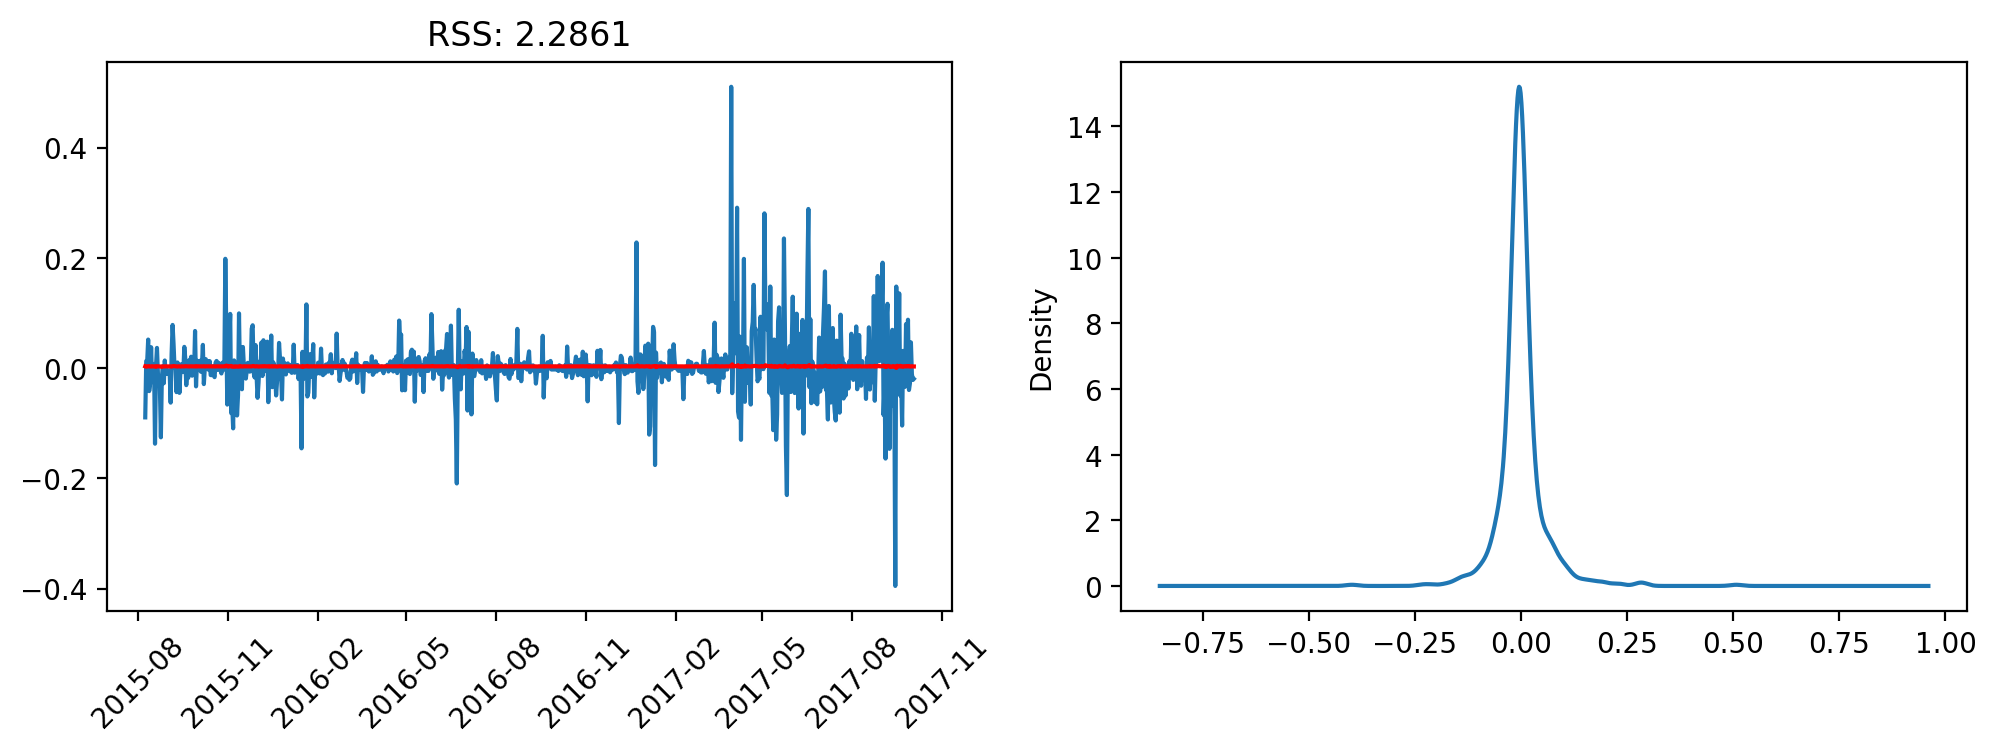

In [16]:
df_3_fitted_values = pd.DataFrame()

for col in df_3_close.columns:
    print(col)
    model = ARIMA(df_3_close_log[col], order=(1,1,0))
    results_ARIMA = model.fit()
    
    df_3_fitted_values[col] = pd.Series(results_ARIMA.fittedvalues, copy=True)
    
    fig = plt.figure(figsize=(12,8), dpi = 200)
    ax1 = fig.add_subplot(221)
    ax1.plot(df_3_close_log_diff[col].index.to_pydatetime(), df_3_close_log_diff[col].values)
    ax1.plot(df_3_close_log_diff[col].index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
    ax1.set_title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df_3_close_log_diff[col])**2))
    plt.xticks(rotation=45)
    
    ax2 = fig.add_subplot(222)
    results_ARIMA.resid.plot(kind  = 'kde')

    plt.show()

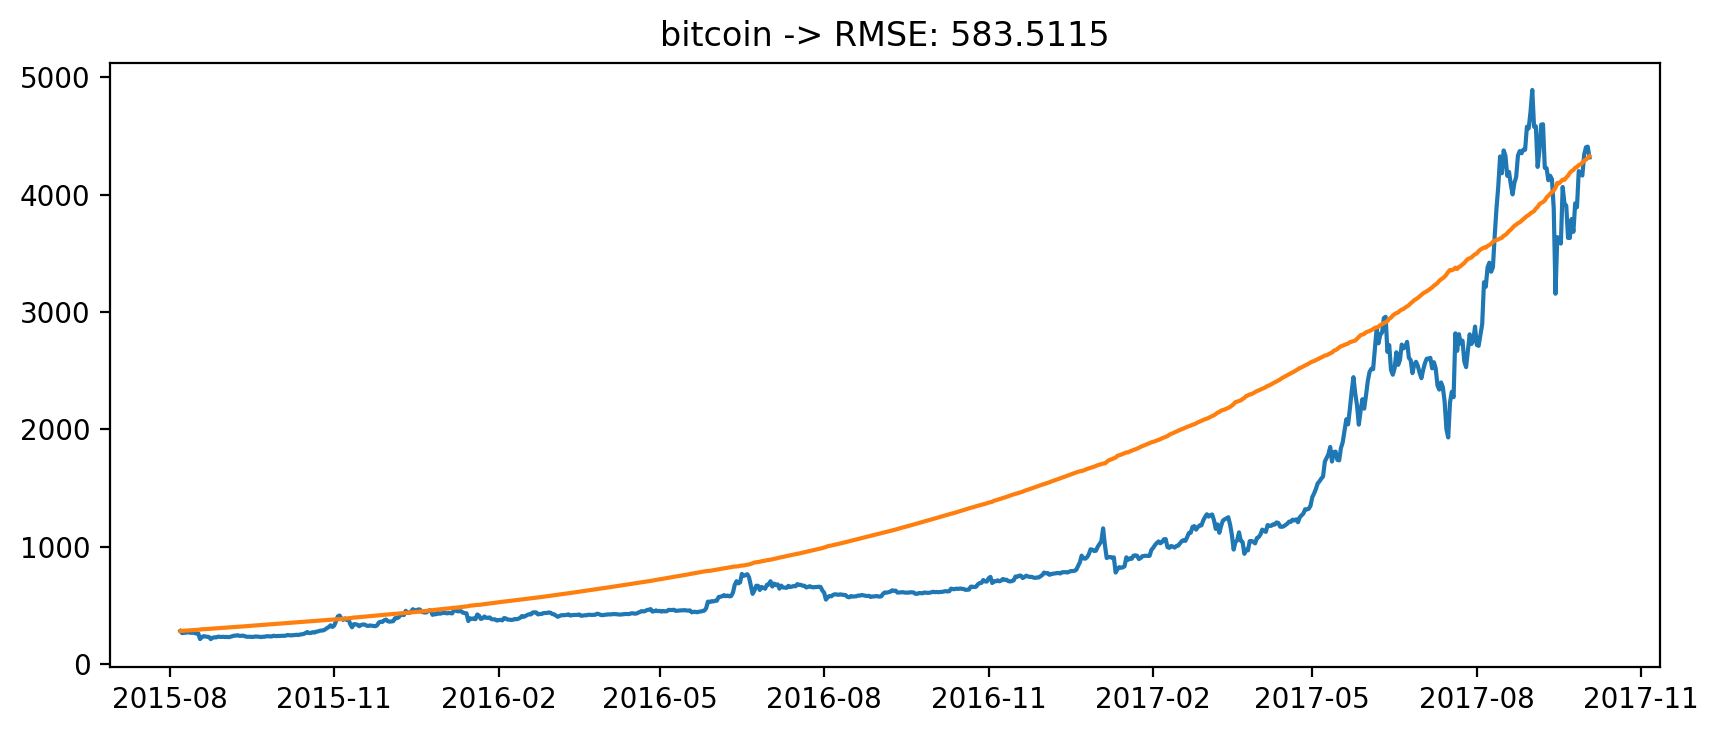

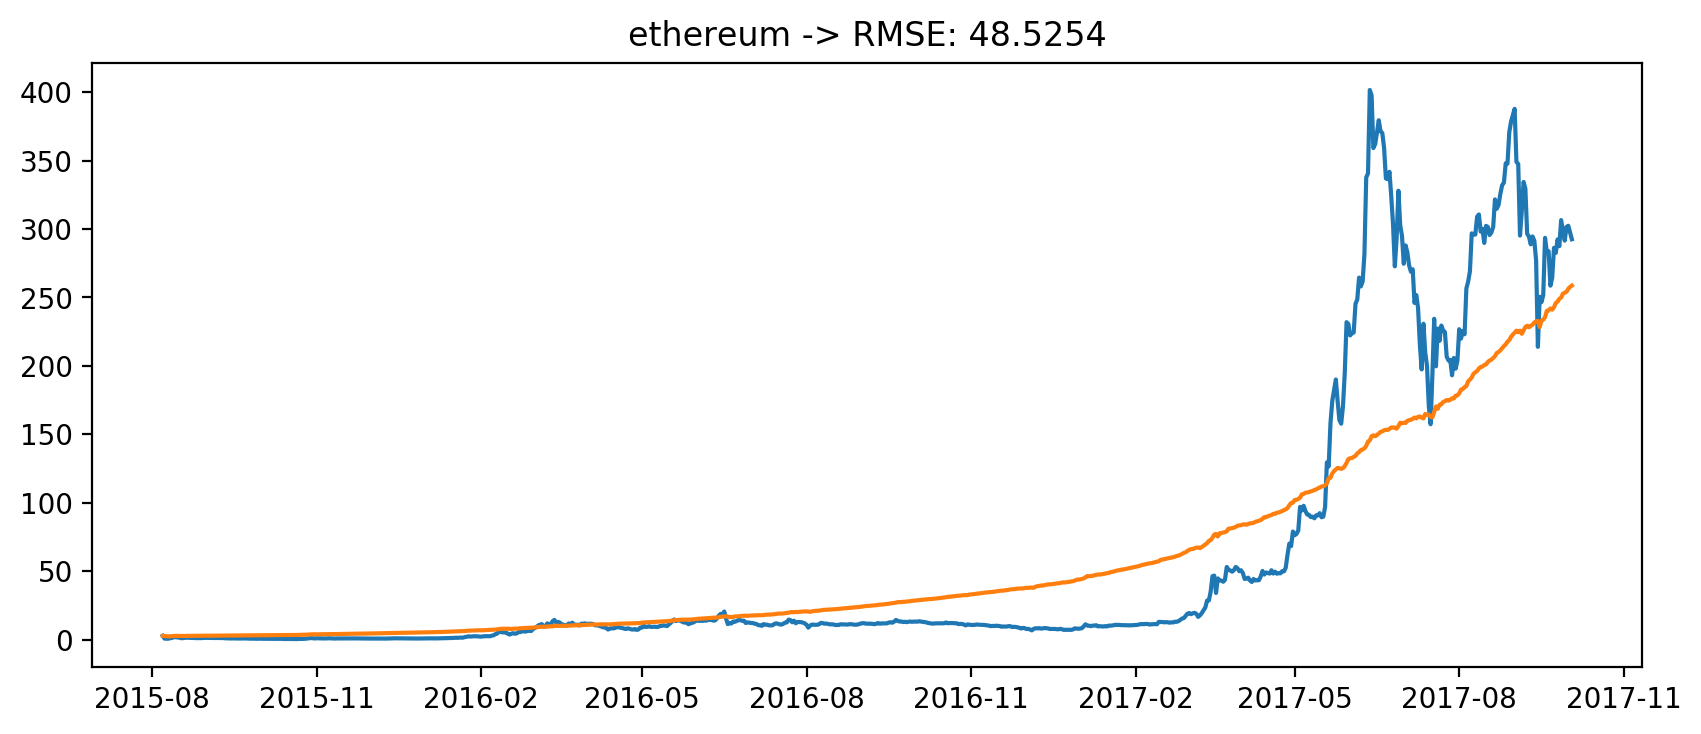

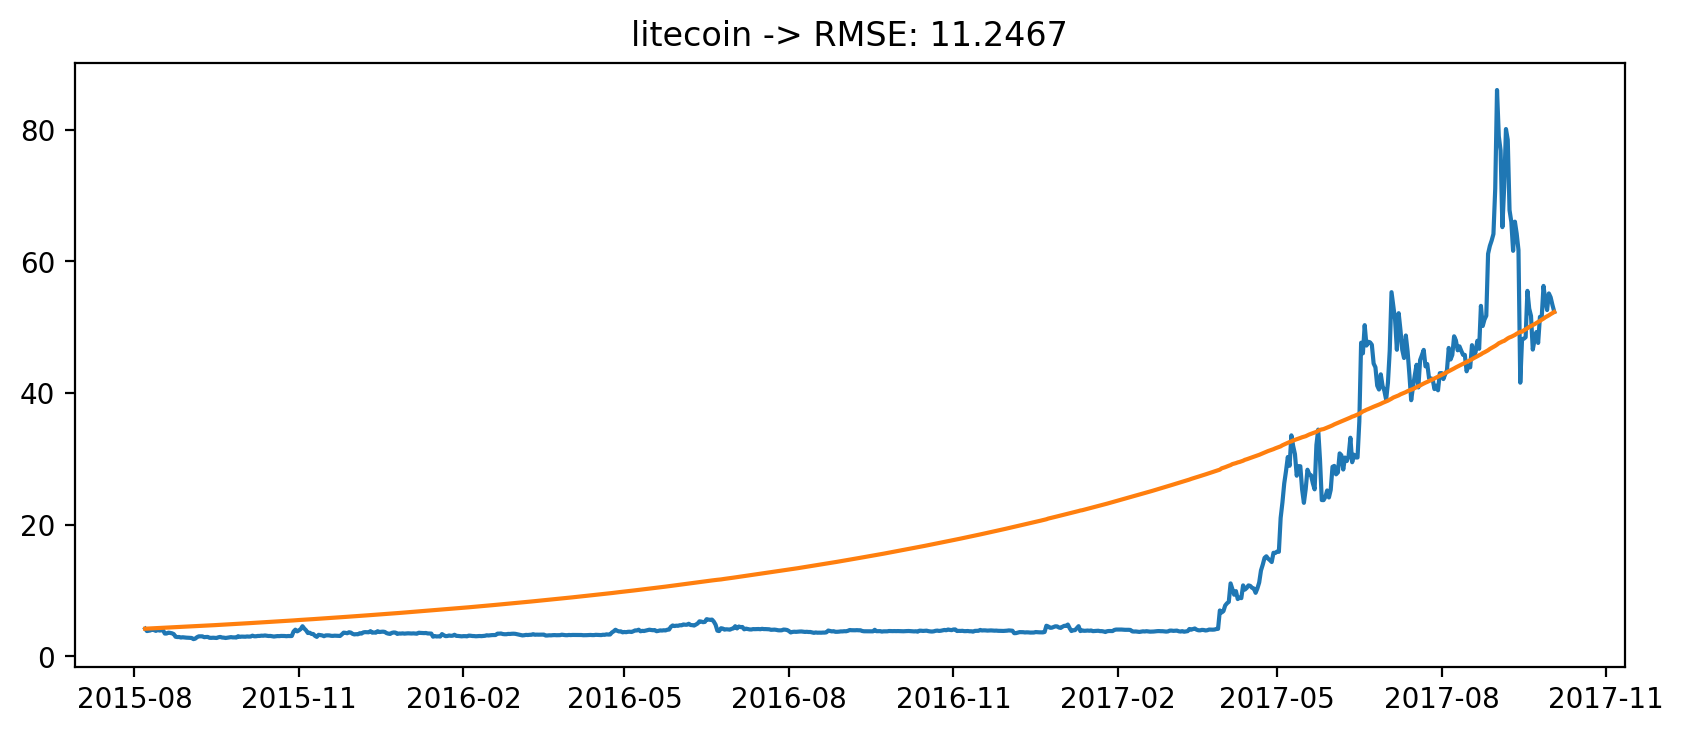

In [17]:
# Lets see how model fits on the data
df_3_predicted_values = pd.DataFrame()

for col in df_3_fitted_values:    
    predictions_ARIMA_diff_cumsum = df_3_fitted_values[col].cumsum()
    predictions_ARIMA_log = pd.Series(df_3_close_log[col].iloc[0], index=df_3_close_log[col].index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

    
    df_3_predicted_values[col] = np.exp(predictions_ARIMA_log)
    plt.figure(figsize = (10,4), dpi = 200)
    plt.plot(df_3_close[col].index.to_pydatetime(), df_3_close[col].values)
    plt.plot(df_3_close[col].index.to_pydatetime(), df_3_predicted_values[col].values)
    plt.title(col + ' -> RMSE: %.4f'% np.sqrt(sum((df_3_predicted_values[col]-df_3_close[col])**2)/len(df_3_close_log[col])))
    plt.show()

## 5.3. Predictions



Printing Mean Squared Error of Predictions...
Test MSE: 0.005065


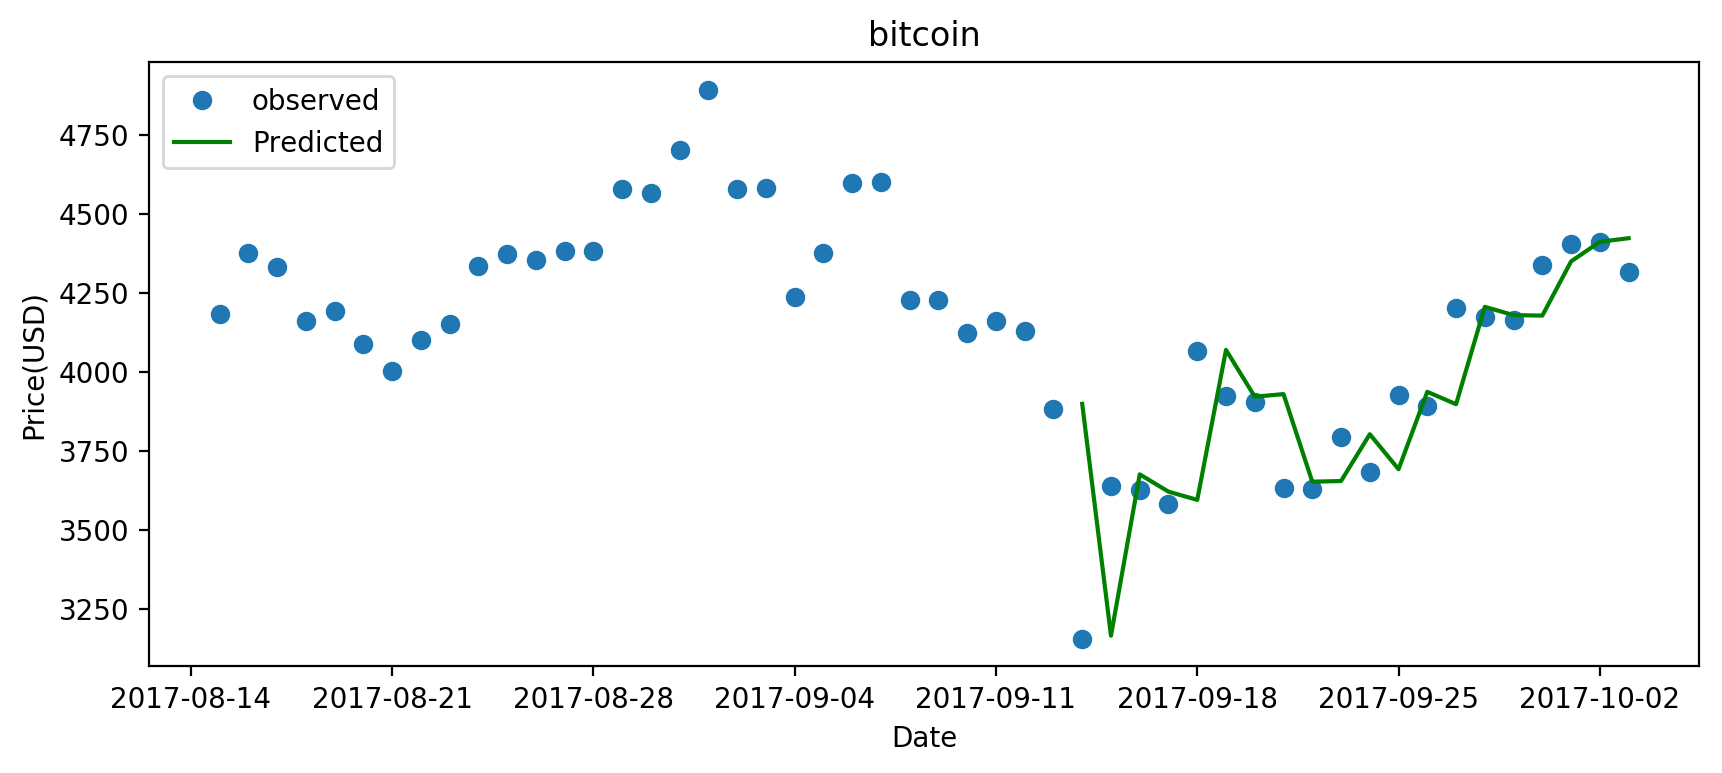



Printing Mean Squared Error of Predictions...
Test MSE: 0.007683


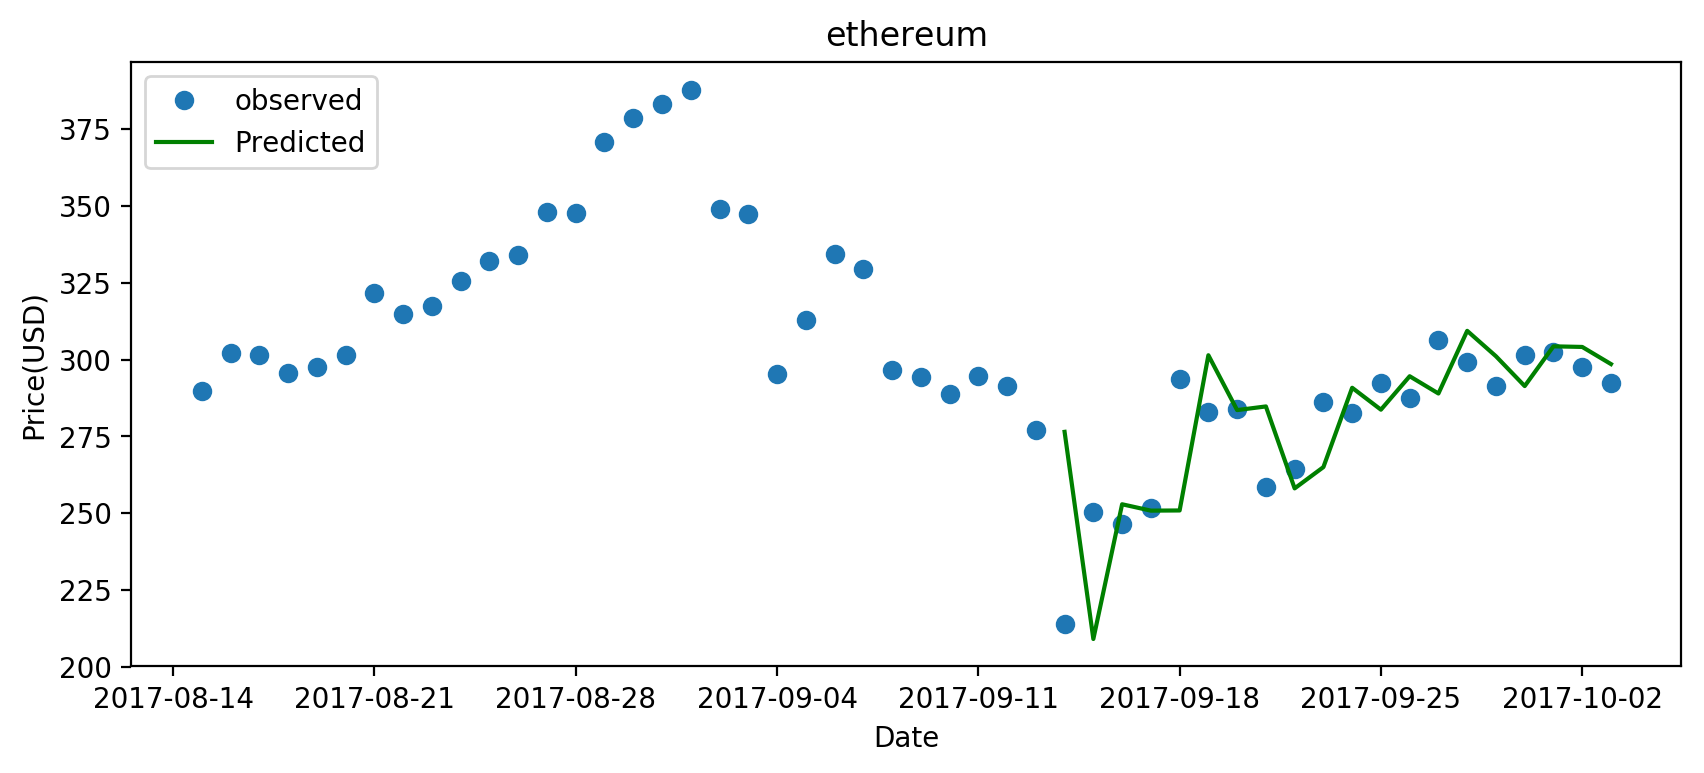



Printing Mean Squared Error of Predictions...
Test MSE: 0.011968


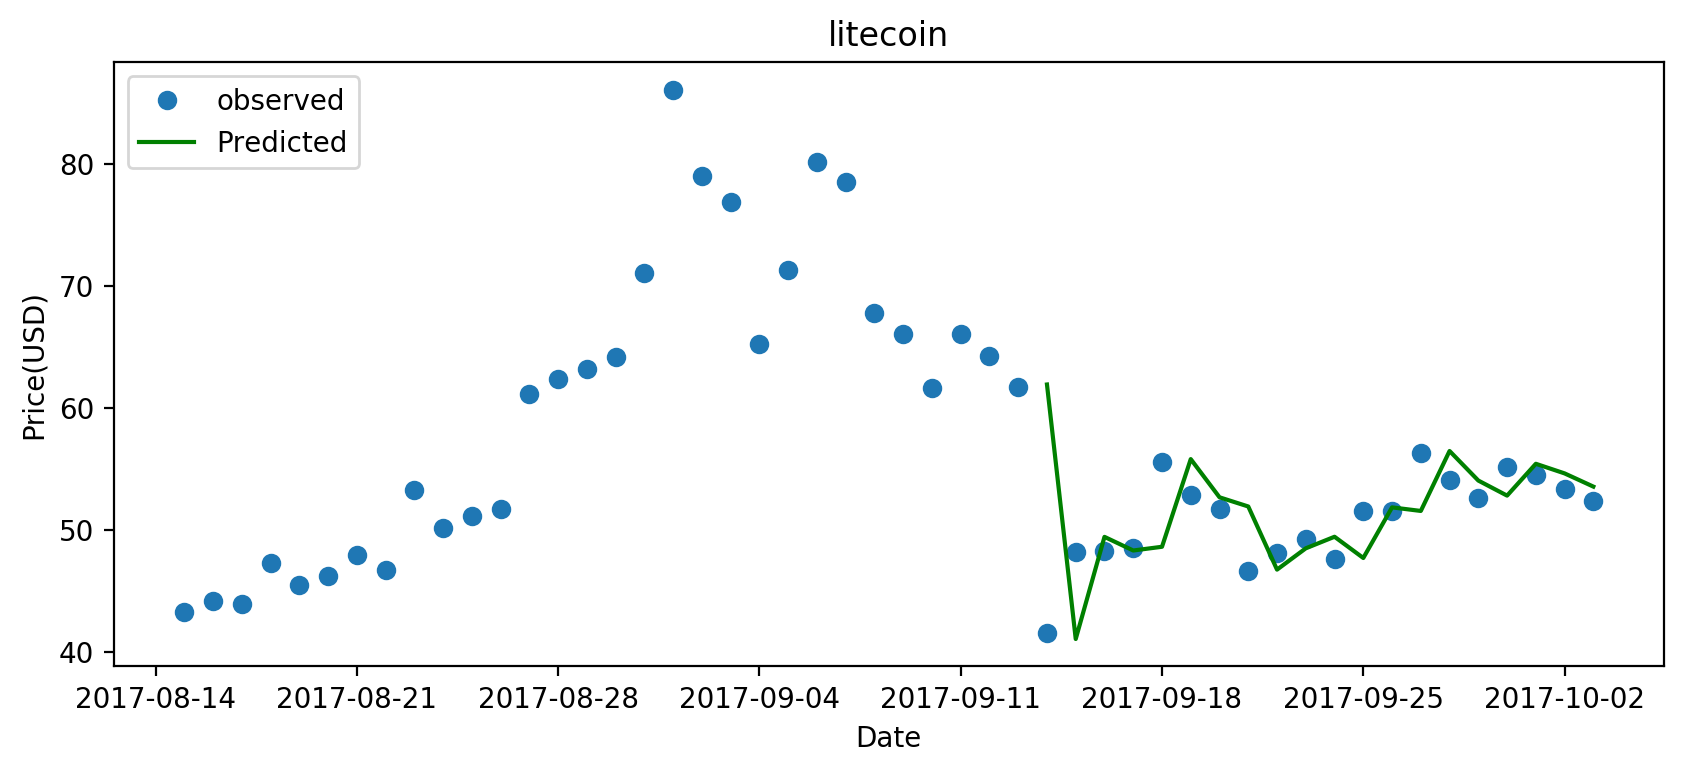

In [19]:
df_3_prediction = pd.DataFrame()

for col in df_3_close.columns:

    size = int(len(df_3_close_log[col]) - 20)
    train, test = df_3_close_log[col][0:size], df_3_close_log[col][size:len(df_3_close_log[col])]
    history = [x for x in train]
    predictions = list()

    for t in range(len(test)):
        model = ARIMA(history, order=(2,1,1))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(float(yhat))
        obs = test[t]
        history.append(obs)

    error = mean_squared_error(test, predictions)

    print('\n')
    print('Printing Mean Squared Error of Predictions...')
    print('Test MSE: %.6f' % error)

    predictions_series = pd.Series(predictions, index = test.index)
    
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(10)
    fig.set_dpi(200)
    ax.set(title=col, xlabel='Date', ylabel='Price(USD)')
    plt.plot(df_3_close[col][-50:], 'o', label='observed')
    plt.plot(np.exp(predictions_series), 'g', label='Predicted')
    legend = ax.legend(loc='upper left')
    legend.get_frame().set_facecolor('w')
    plt.show()